Start 

V 2


ADAPTIVE TECHNICAL OPPORTUNITY DETECTION
Average daily dollar volume: $310,363,299
Dollar bar size (10x daily): $3,103,632,994
Created 248 dollar bars


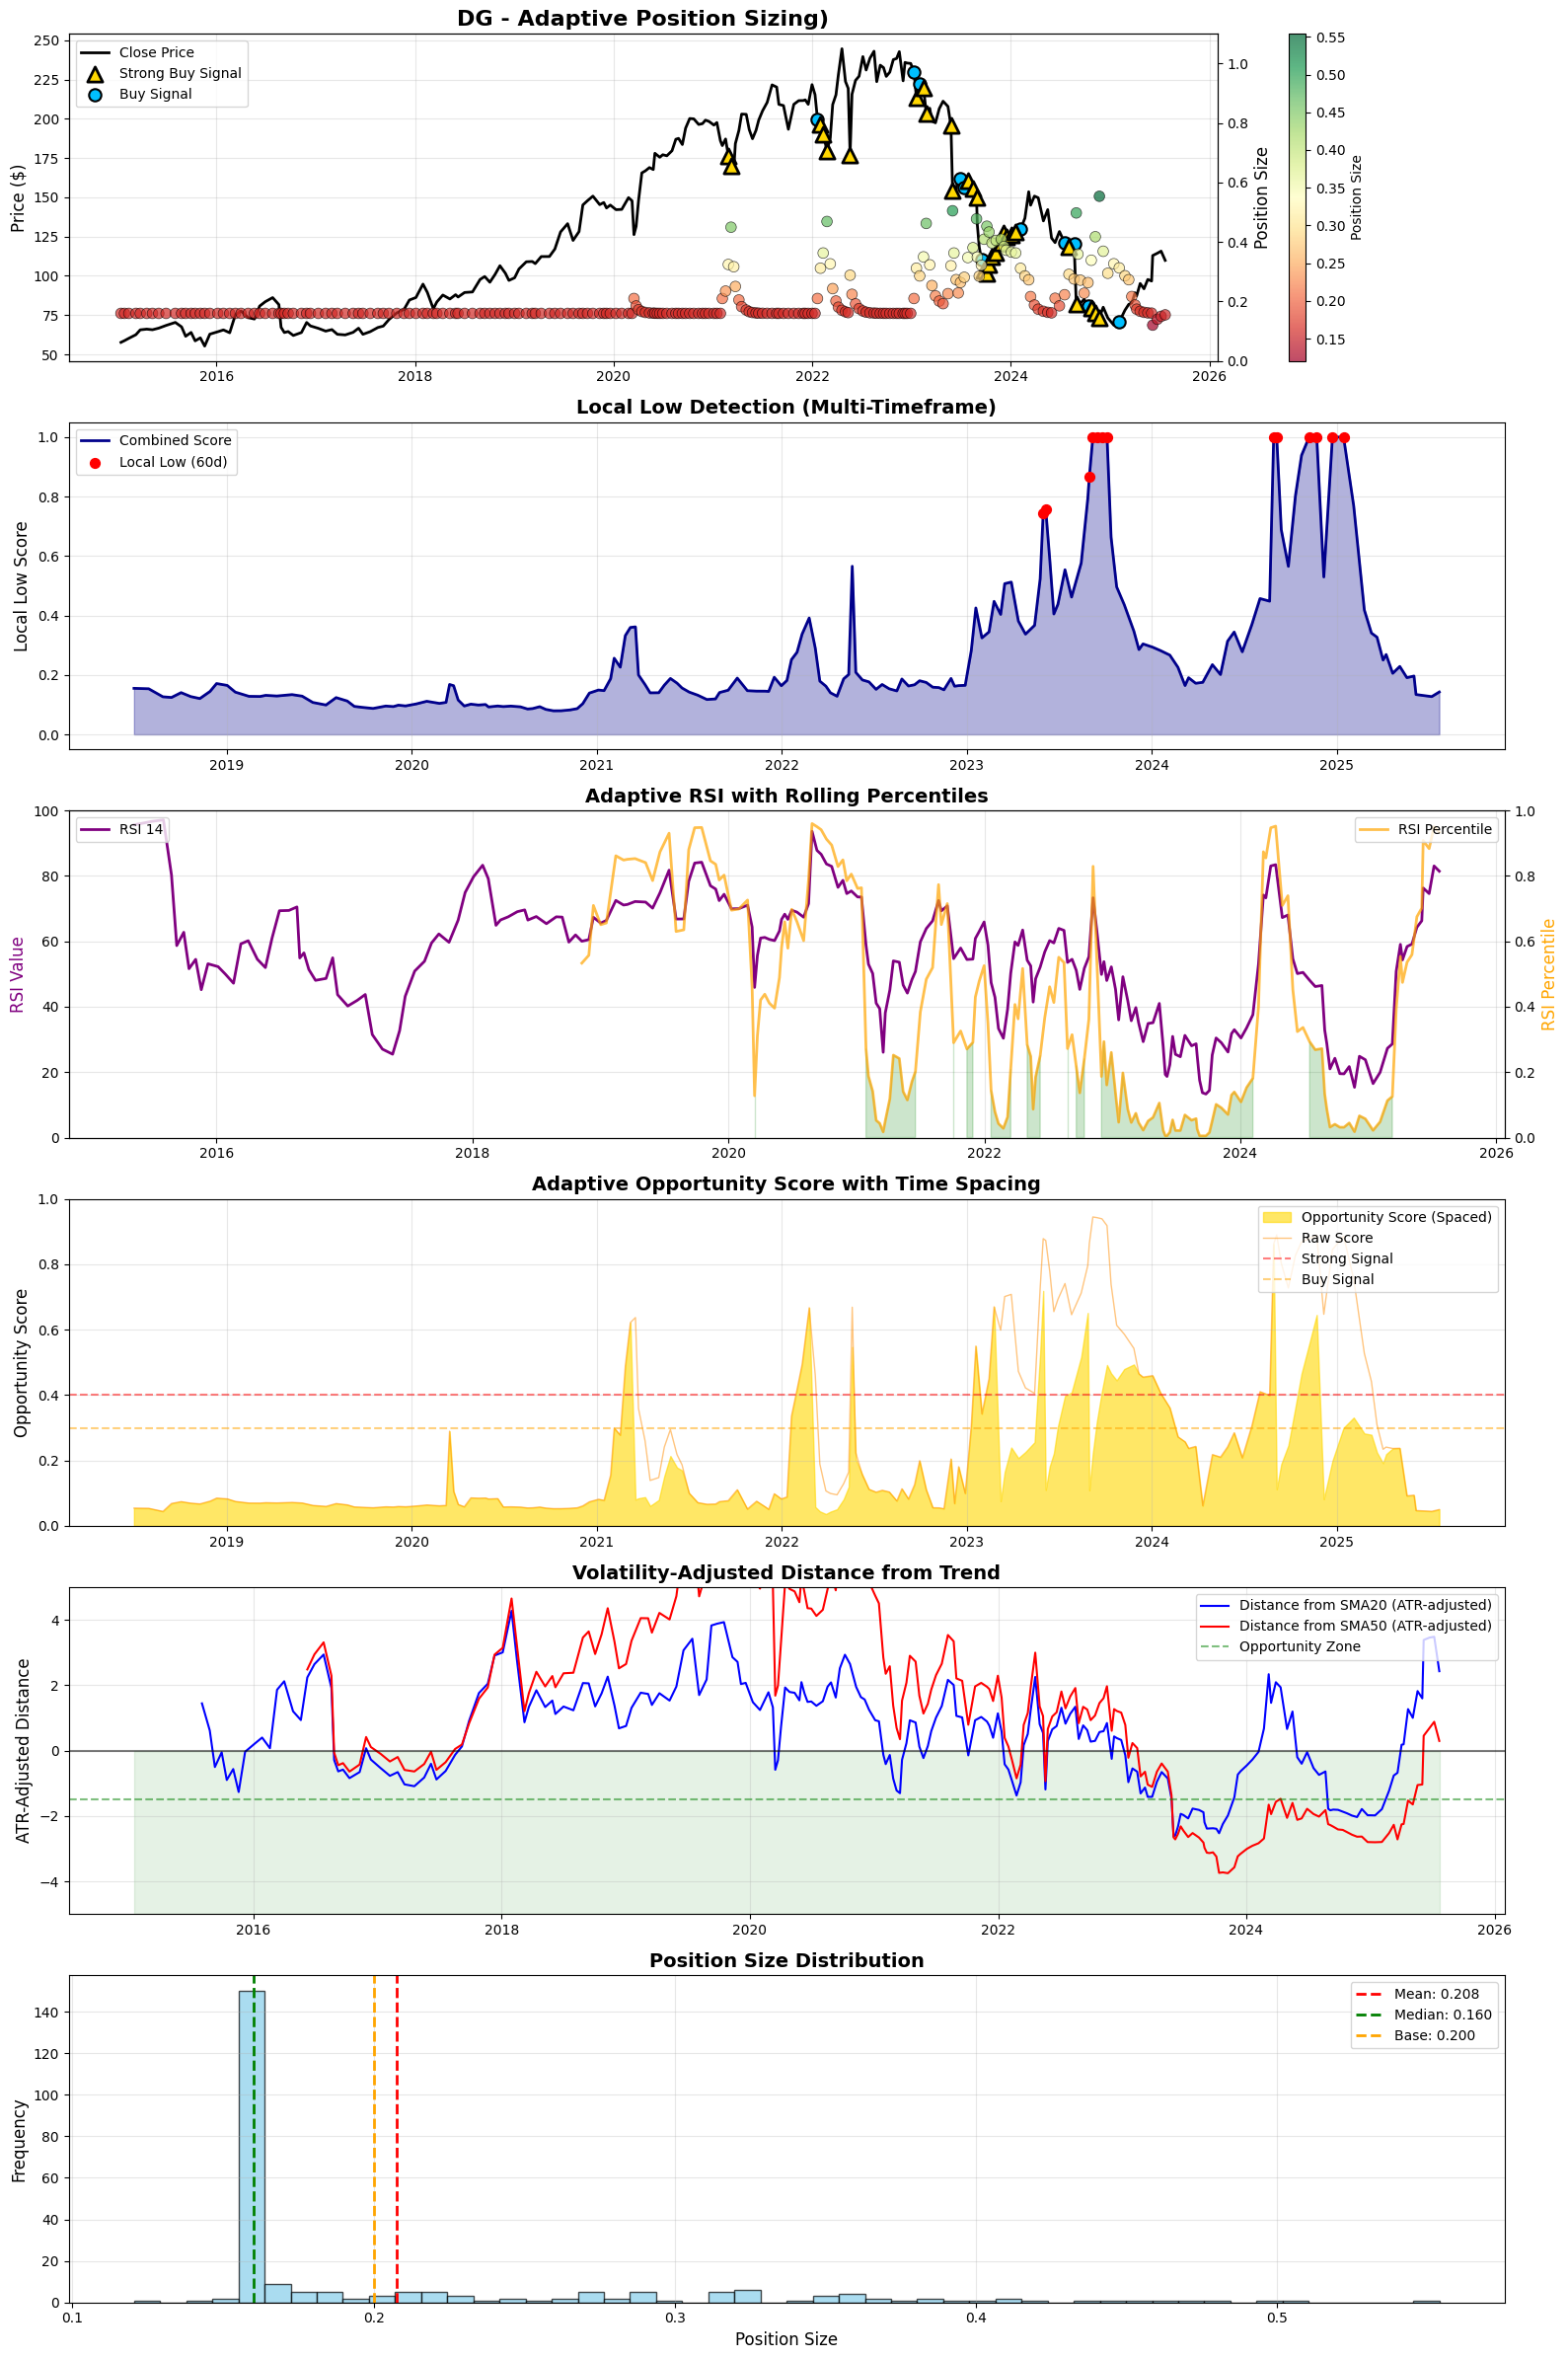


ADAPTIVE OPPORTUNITY ANALYSIS

Opportunities by Year:
      Strong_Buy_Signal  Buy_Signal  Position_Size_Smoothed
Year                                                       
2015                  0           0                0.160000
2016                  0           0                0.160000
2017                  0           0                0.160000
2018                  0           0                0.160000
2019                  0           0                0.160000
2020                  0           0                0.163704
2021                  2           2                0.191621
2022                  4           5                0.200656
2023                 16          21                0.334387
2024                  7          11                0.286575
2025                  0           1                0.199841

Signal Coverage Check:
2016: 0 strong signals, Avg position: 0.160, Max position: 0.160
2020: 0 strong signals, Avg position: 0.164, Max position: 0.210
2021: 2 str

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
from scipy import stats, signal
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

# USER INPUTS 
TICKER = "DG"                               
START_DATE = "2015-01-01"                
END_DATE = datetime.now()                      
THRESHOLD_MULTIPLIER = 10
STRONG_BUY_THRESHOLD = 0.4
BUY_THRESHOLD = 0.3


# POSITION SIZING PARAMETERS
MAX_POSITION_SIZE = 1.0              
MIN_POSITION_SIZE = 0.01
BASE_POSITION_SIZE = 0.2            # Normal allocation

# Adaptive Parameters
LOOKBACK_SHORT = 20                # Short-term local lows
LOOKBACK_MEDIUM = 60                # Medium-term local lows
LOOKBACK_LONG = 120                 # Long-term local lows
PERCENTILE_LOOKBACK = 252           # For adaptive thresholds
MIN_BARS_BETWEEN_SIGNALS = 10      # Prevent clustering

print(f"\n{'='*60}")
print(f"ADAPTIVE TECHNICAL OPPORTUNITY DETECTION")
print(f"{'='*60}")
print(f"Downloading {TICKER} data from {START_DATE}...")

data = yf.download(TICKER, start=START_DATE, end=END_DATE, interval="1d", progress=False)

if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Calculate dollar volume and threshold
avg_dollar_volume = data['Close'] * data['Volume']
avg_dollar_volume = avg_dollar_volume.mean()

# Set dollar bar size as a percent/multiple of average daily volume
DOLLAR_BAR_SIZE = avg_dollar_volume * THRESHOLD_MULTIPLIER

print(f"Average daily dollar volume: ${avg_dollar_volume:,.0f}")
print(f"Dollar bar size ({THRESHOLD_MULTIPLIER}x daily): ${DOLLAR_BAR_SIZE:,.0f}")

# Add Dollar_Volume column for bar construction
data['Dollar_Volume'] = data['Close'] * data['Volume']

def create_dollar_bars(data, threshold):
    bars = []
    cumulative_volume = 0
    temp_open = None
    temp_volume = 0
    temp_trades = 0
    temp_vwap_numerator = 0
    temp_high_list = []
    temp_low_list = []
    for idx, row in data.iterrows():
        if temp_open is None:
            temp_open = row['Open']
            temp_high = row['High']
            temp_low = row['Low']
            start_date = idx

        temp_high = max(temp_high, row['High'])
        temp_low = min(temp_low, row['Low'])
        temp_high_list.append(row['High'])
        temp_low_list.append(row['Low'])

        cumulative_volume += row['Dollar_Volume']
        temp_volume += row['Volume']
        temp_trades += 1
        temp_vwap_numerator += row['Close'] * row['Volume']

        if cumulative_volume >= threshold:
            vwap = temp_vwap_numerator / temp_volume if temp_volume > 0 else row['Close']

            # Calculate average high/low for better representation
            avg_high = np.mean(temp_high_list) if temp_high_list else temp_high
            avg_low = np.mean(temp_low_list) if temp_low_list else temp_low

            bars.append({
                'Date': idx,
                'Open': temp_open,
                'High': temp_high,
                'Low': temp_low,
                'Avg_High': avg_high,
                'Avg_Low': avg_low,
                'Close': row['Close'],
                'VWAP': vwap,
                'Dollar_Volume': cumulative_volume,
                'Volume': temp_volume,
                'Trade_Count': temp_trades,
                'Bar_Duration_Days': (idx - start_date).days + 1
            })

            cumulative_volume = 0
            temp_volume = 0
            temp_trades = 0
            temp_open = None
            temp_vwap_numerator = 0
            temp_high_list = []
            temp_low_list = []

    dollar_bars = pd.DataFrame(bars)
    dollar_bars.set_index('Date', inplace=True)
    return dollar_bars

dollar_bars = create_dollar_bars(data, DOLLAR_BAR_SIZE)
print(f"Created {len(dollar_bars)} dollar bars")

# Calculate returns
dollar_bars['Returns'] = dollar_bars['Close'].pct_change()
dollar_bars['Log_Returns'] = np.log(dollar_bars['Close'] / dollar_bars['Close'].shift(1))

# ADAPTIVE TECHNICAL INDICATORS
"""
Calculate indicators with adaptive thresholds based on recent history
"""

# 1. Adaptive RSI
def calculate_rsi(prices, period=14):
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period, min_periods=period//2).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=period//2).mean()
    loss = loss.replace(0, 0.0001)
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

dollar_bars['RSI_14'] = calculate_rsi(dollar_bars['Close'])
dollar_bars['RSI_7'] = calculate_rsi(dollar_bars['Close'], period=7)

# Calculate RSI percentiles (adaptive thresholds)
dollar_bars['RSI_Percentile'] = dollar_bars['RSI_14'].rolling(
    window=PERCENTILE_LOOKBACK, min_periods=60
).rank(pct=True)

# 2. ATR for volatility-adjusted signals
def calculate_atr(high, low, close, period=14):
    high_low = high - low
    high_close = abs(high - close.shift(1))
    low_close = abs(low - close.shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=period, min_periods=period//2).mean()
    return atr

dollar_bars['ATR'] = calculate_atr(dollar_bars['High'], dollar_bars['Low'], dollar_bars['Close'])
dollar_bars['ATR_Percent'] = dollar_bars['ATR'] / dollar_bars['Close']

# 3. Bollinger Bands
def calculate_adaptive_bollinger(prices, window=20, num_std=2):
    rolling_mean = prices.rolling(window=window, min_periods=window//2).mean()
    rolling_std = prices.rolling(window=window, min_periods=window//2).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    bb_position = (prices - lower_band) / (upper_band - lower_band)
    return upper_band, rolling_mean, lower_band, bb_position

dollar_bars['BB_Upper'], dollar_bars['BB_Middle'], dollar_bars['BB_Lower'], dollar_bars['BB_Position'] = \
    calculate_adaptive_bollinger(dollar_bars['Close'])

# BB position percentile
dollar_bars['BB_Percentile'] = dollar_bars['BB_Position'].rolling(
    window=PERCENTILE_LOOKBACK, min_periods=60
).rank(pct=True)

# 4. Stochastic with adaptive levels
def calculate_stochastic(high, low, close, k_period=14):
    lowest_low = low.rolling(window=k_period, min_periods=k_period//2).min()
    highest_high = high.rolling(window=k_period, min_periods=k_period//2).max()
    k_percent = 100 * (close - lowest_low) / (highest_high - lowest_low + 0.0001)
    return k_percent

dollar_bars['Stoch_K'] = calculate_stochastic(dollar_bars['High'], dollar_bars['Low'], dollar_bars['Close'])
dollar_bars['Stoch_Percentile'] = dollar_bars['Stoch_K'].rolling(
    window=PERCENTILE_LOOKBACK, min_periods=60
).rank(pct=True)

# LOCAL LOW DETECTION
"""
Identify local lows across multiple timeframes
"""

def detect_local_lows(prices, window):
    """
    Detect if current price is a local low within the window
    Returns a score from 0 to 1 indicating how significant the low is
    """
    # Rolling minimum
    rolling_min = prices.rolling(window=window, min_periods=window//2).min()
    
    # How close is current price to rolling minimum?
    distance_from_min = (prices - rolling_min) / rolling_min
    
    # Score: closer to minimum = higher score
    score = 1 / (1 + distance_from_min * 10)
    
    # Binary signal: is this THE lowest point in the window?
    is_local_low = prices == rolling_min
    
    return score, is_local_low

# Calculate local lows for multiple timeframes
dollar_bars['Local_Low_Score_Short'], dollar_bars['Is_Local_Low_Short'] = \
    detect_local_lows(dollar_bars['Close'], LOOKBACK_SHORT)

dollar_bars['Local_Low_Score_Medium'], dollar_bars['Is_Local_Low_Medium'] = \
    detect_local_lows(dollar_bars['Close'], LOOKBACK_MEDIUM)

dollar_bars['Local_Low_Score_Long'], dollar_bars['Is_Local_Low_Long'] = \
    detect_local_lows(dollar_bars['Close'], LOOKBACK_LONG)

# Combined local low score
dollar_bars['Local_Low_Score'] = (
    dollar_bars['Local_Low_Score_Short'] * 0.3 +
    dollar_bars['Local_Low_Score_Medium'] * 0.4 +
    dollar_bars['Local_Low_Score_Long'] * 0.3
)

# TREND-RELATIVE POSITIONING

# Multiple moving averages
dollar_bars['SMA_20'] = dollar_bars['Close'].rolling(window=20, min_periods=10).mean()
dollar_bars['SMA_50'] = dollar_bars['Close'].rolling(window=50, min_periods=25).mean()
dollar_bars['SMA_200'] = dollar_bars['Close'].rolling(window=200, min_periods=100).mean()

# Distance from moving averages
dollar_bars['Distance_SMA20'] = (dollar_bars['Close'] - dollar_bars['SMA_20']) / dollar_bars['SMA_20']
dollar_bars['Distance_SMA50'] = (dollar_bars['Close'] - dollar_bars['SMA_50']) / dollar_bars['SMA_50']
dollar_bars['Distance_SMA200'] = (dollar_bars['Close'] - dollar_bars['SMA_200']) / dollar_bars['SMA_200']

# Volatility-adjusted distance
dollar_bars['Distance_SMA20_Adjusted'] = dollar_bars['Distance_SMA20'] / (dollar_bars['ATR_Percent'] + 0.01)
dollar_bars['Distance_SMA50_Adjusted'] = dollar_bars['Distance_SMA50'] / (dollar_bars['ATR_Percent'] + 0.01)

# PATTERN RECOGNITION 
"""
Simple pattern detection for additional confirmation
"""

def detect_double_bottom(lows, window=20, tolerance=0.02):
    """
    Detect double bottom pattern
    """
    if len(lows) < window:
        return pd.Series(index=lows.index, data=0)
    
    # Find recent lows
    recent_min_1 = lows.rolling(window=window//2).min()
    recent_min_2 = lows.rolling(window=window).min()
    
    # Check if two lows are similar (within tolerance)
    double_bottom = abs(recent_min_1 - recent_min_2) / recent_min_2 < tolerance
    
    return double_bottom.astype(int)

def detect_higher_low(lows, window=40):
    """
    Detect higher low pattern (bullish)
    """
    if len(lows) < window:
        return pd.Series(index=lows.index, data=0)
    
    # Compare current low to previous low
    prev_low = lows.shift(window//2).rolling(window=window//2).min()
    curr_low = lows.rolling(window=window//2).min()
    
    higher_low = curr_low > prev_low * 1.01  # At least 1% higher
    
    return higher_low.astype(int)

dollar_bars['Double_Bottom'] = detect_double_bottom(dollar_bars['Low'])
dollar_bars['Higher_Low'] = detect_higher_low(dollar_bars['Low'])

# ===== ADAPTIVE OPPORTUNITY SCORING =====
"""
"""

def calculate_adaptive_opportunity_score(row):
    """
    Calculate opportunity score based on technical factors only
    """
    score = 0
    
    # 1. Local Low Score (35% weight)
    score += row['Local_Low_Score'] * 0.35
    
    # 2. Relative RSI Score (25% weight)
    rsi_percentile = row['RSI_Percentile']
    if pd.notna(rsi_percentile):
        # Universal RSI scoring - low percentile is good
        rsi_score = max(0, (0.3 - rsi_percentile) / 0.3)
        score += rsi_score * 0.25
    
    # 3. Trend Distance Score (20% weight)
    # Use both short and medium term distances
    distance_20 = row['Distance_SMA20_Adjusted']
    distance_50 = row['Distance_SMA50_Adjusted']
    
    # Combined distance score
    if distance_20 < -1 or distance_50 < -1.5:
        trend_score = min(1, (abs(distance_20) + abs(distance_50)) / 4)
    else:
        trend_score = 0
    score += trend_score * 0.2
    
    # 4. Bollinger Band Score (10% weight)
    bb_percentile = row['BB_Percentile']
    if pd.notna(bb_percentile):
        bb_score = max(0, (0.25 - bb_percentile) / 0.25)
        score += bb_score * 0.1
    
    # 5. Stochastic Score (5% weight)
    stoch_percentile = row['Stoch_Percentile']
    if pd.notna(stoch_percentile):
        stoch_score = max(0, (0.3 - stoch_percentile) / 0.3)
        score += stoch_score * 0.05
    
    # 6. Pattern Bonus (5% weight)
    pattern_score = 0
    if row['Double_Bottom'] == 1:
        pattern_score += 0.5
    if row['Higher_Low'] == 1:
        pattern_score += 0.5
    score += min(pattern_score, 1) * 0.05
    
    return min(score, 1)  # Cap at 1

# Calculate opportunity scores
dollar_bars['Opportunity_Score'] = dollar_bars.apply(calculate_adaptive_opportunity_score, axis=1)

# TIME-BASED SPACING 
"""
Implement recharge period to prevent clustering
"""

def apply_time_spacing(scores, min_bars=MIN_BARS_BETWEEN_SIGNALS, decay_factor=0.9):
    
    adjusted_scores = scores.copy()
    last_signal_idx = -999
    
    for i in range(len(scores)):
        if i - last_signal_idx < min_bars:
            # Reduce score based on proximity to last signal
            proximity_factor = (i - last_signal_idx) / min_bars
            adjusted_scores.iloc[i] *= (proximity_factor ** decay_factor)
        
        # Update last signal if this is a strong opportunity
        if adjusted_scores.iloc[i] > 0.6:
            last_signal_idx = i
    
    return adjusted_scores

dollar_bars['Opportunity_Score_Spaced'] = apply_time_spacing(dollar_bars['Opportunity_Score'])

# POSITION SIZE CALCULATION

def calculate_adaptive_position_size(row):
    
    opp_score = row['Opportunity_Score_Spaced']
    
    # Base position
    base = BASE_POSITION_SIZE
    
    # Scale position based on opportunity score
    if opp_score > 0.8:  # Extreme opportunity
        position_size = base * 3.0
    elif opp_score > 0.6:  # Strong opportunity
        position_size = base * 2.5
    elif opp_score > 0.4:  # Moderate opportunity
        position_size = base * 1.8
    elif opp_score > 0.25:  # Mild opportunity
        position_size = base * 1.3
    else:  # No clear opportunity
        position_size = base * 0.8
    
    # Additional adjustments
    
    # 1. Boost for confirmed local lows
    if row['Is_Local_Low_Medium']:
        position_size *= 1.2
    
    # 2. Boost for extreme oversold
    if row['RSI_Percentile'] < 0.1:
        position_size *= 1.15
    
    # 3. Reduce in extreme overbought
    if row['RSI_Percentile'] > 0.9 and row['BB_Percentile'] > 0.9:
        position_size *= 0.5
    
    # Apply constraints
    position_size = np.clip(position_size, MIN_POSITION_SIZE, MAX_POSITION_SIZE)
    
    return position_size

# Calculate position sizes
dollar_bars['Position_Size'] = dollar_bars.apply(calculate_adaptive_position_size, axis=1)

# Smooth slightly
dollar_bars['Position_Size_Smoothed'] = dollar_bars['Position_Size'].ewm(span=3, min_periods=1).mean()

# SIGNAL GENERATION 
dollar_bars['Strong_Buy_Signal'] = (dollar_bars['Opportunity_Score_Spaced'] > STRONG_BUY_THRESHOLD).astype(int)
dollar_bars['Buy_Signal'] = (dollar_bars['Opportunity_Score_Spaced'] > BUY_THRESHOLD).astype(int)

#  VISUALIZATION
fig, axes = plt.subplots(6, 1, figsize=(16, 24), sharex=False)

# Plot 1: Price with position sizes
ax1 = axes[0]
ax1.plot(dollar_bars.index, dollar_bars['Close'], label='Close Price', color='black', linewidth=2)

ax1_twin = ax1.twinx()

# Position sizes
scatter = ax1_twin.scatter(dollar_bars.index, dollar_bars['Position_Size_Smoothed'], 
                          c=dollar_bars['Position_Size_Smoothed'], cmap='RdYlGn', 
                          alpha=0.7, s=60, edgecolor='black', linewidth=0.5)

# Mark strong buy signals
strong_buys = dollar_bars[dollar_bars['Strong_Buy_Signal'] == 1]
ax1.scatter(strong_buys.index, strong_buys['Close'], color='gold', s=120, 
           marker='^', label='Strong Buy Signal', zorder=5, edgecolors='black', linewidth=2)

buy_buys = dollar_bars[(dollar_bars['Buy_Signal'] == 1) & (dollar_bars['Strong_Buy_Signal'] == 0)]
ax1.scatter(buy_buys.index, buy_buys['Close'], color='deepskyblue', s=80,
            marker='o', label='Buy Signal', zorder=4, edgecolors='black', linewidth=1.5)

ax1.set_title(f'{TICKER} - Adaptive Position Sizing)', fontsize=16, fontweight='bold')
ax1.set_ylabel('Price ($)', fontsize=12)
ax1_twin.set_ylabel('Position Size', fontsize=12)
ax1_twin.set_ylim(0, 1.1)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax1_twin)
cbar.set_label('Position Size', fontsize=10)

# Plot 2: Local Low Scores
ax2 = axes[1]
ax2.plot(dollar_bars.index, dollar_bars['Local_Low_Score'], 
         label='Combined Score', color='darkblue', linewidth=2)
ax2.fill_between(dollar_bars.index, 0, dollar_bars['Local_Low_Score'], 
                 alpha=0.3, color='darkblue')
ax2.scatter(dollar_bars[dollar_bars['Is_Local_Low_Medium']].index, 
           dollar_bars[dollar_bars['Is_Local_Low_Medium']]['Local_Low_Score'],
           color='red', s=50, label='Local Low (60d)', zorder=5)
ax2.set_ylabel('Local Low Score', fontsize=12)
ax2.set_title('Local Low Detection (Multi-Timeframe)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Adaptive RSI
ax3 = axes[2]
ax3.plot(dollar_bars.index, dollar_bars['RSI_14'], label='RSI 14', color='purple', linewidth=2)
ax3_twin = ax3.twinx()
ax3_twin.plot(dollar_bars.index, dollar_bars['RSI_Percentile'], 
              label='RSI Percentile', color='orange', linewidth=2, alpha=0.7)
ax3_twin.fill_between(dollar_bars.index, 0, dollar_bars['RSI_Percentile'], 
                      where=dollar_bars['RSI_Percentile']<0.3, alpha=0.2, color='green')

ax3.set_ylabel('RSI Value', fontsize=12, color='purple')
ax3_twin.set_ylabel('RSI Percentile', fontsize=12, color='orange')
ax3.set_ylim(0, 100)
ax3_twin.set_ylim(0, 1)
ax3.set_title('Adaptive RSI with Rolling Percentiles', fontsize=14, fontweight='bold')
ax3.legend(loc='upper left')
ax3_twin.legend(loc='upper right')
ax3.grid(True, alpha=0.3)

# Plot 4: Opportunity Score
ax4 = axes[3]
ax4.fill_between(dollar_bars.index, 0, dollar_bars['Opportunity_Score_Spaced'], 
                 alpha=0.6, color='gold', label='Opportunity Score (Spaced)')
ax4.plot(dollar_bars.index, dollar_bars['Opportunity_Score'], 
         color='darkorange', linewidth=1, alpha=0.5, label='Raw Score')
ax4.axhline(y=STRONG_BUY_THRESHOLD, color='red', linestyle='--', alpha=0.5, label='Strong Signal')
ax4.axhline(y=BUY_THRESHOLD, color='orange', linestyle='--', alpha=0.5, label='Buy Signal')

ax4.set_title('Adaptive Opportunity Score with Time Spacing', fontsize=14, fontweight='bold')
ax4.set_ylabel('Opportunity Score', fontsize=12)
ax4.set_ylim(0, 1)
ax4.legend(loc='upper right')
ax4.grid(True, alpha=0.3)

# Plot 5: Volatility-Adjusted Distance from Trend
ax5 = axes[4]
ax5.plot(dollar_bars.index, dollar_bars['Distance_SMA20_Adjusted'], 
         label='Distance from SMA20 (ATR-adjusted)', color='blue', linewidth=1.5)
ax5.plot(dollar_bars.index, dollar_bars['Distance_SMA50_Adjusted'], 
         label='Distance from SMA50 (ATR-adjusted)', color='red', linewidth=1.5)
ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax5.axhline(y=-1.5, color='green', linestyle='--', alpha=0.5, label='Opportunity Zone')
ax5.fill_between(dollar_bars.index, -5, 0, alpha=0.1, color='green')

ax5.set_title('Volatility-Adjusted Distance from Trend', fontsize=14, fontweight='bold')
ax5.set_ylabel('ATR-Adjusted Distance', fontsize=12)
ax5.set_ylim(-5, 5)
ax5.legend(loc='upper right')
ax5.grid(True, alpha=0.3)

# Plot 6: Position Size Distribution
ax6 = axes[5]
ax6.hist(dollar_bars['Position_Size_Smoothed'].dropna(), bins=50, 
         alpha=0.7, color='skyblue', edgecolor='black')
ax6.axvline(dollar_bars['Position_Size_Smoothed'].mean(), color='red', 
           linestyle='--', linewidth=2, label=f"Mean: {dollar_bars['Position_Size_Smoothed'].mean():.3f}")
ax6.axvline(dollar_bars['Position_Size_Smoothed'].median(), color='green', 
           linestyle='--', linewidth=2, label=f"Median: {dollar_bars['Position_Size_Smoothed'].median():.3f}")
ax6.axvline(BASE_POSITION_SIZE, color='orange', 
           linestyle='--', linewidth=2, label=f"Base: {BASE_POSITION_SIZE:.3f}")

ax6.set_title('Position Size Distribution', fontsize=14, fontweight='bold')
ax6.set_xlabel('Position Size', fontsize=12)
ax6.set_ylabel('Frequency', fontsize=12)
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# OPPORTUNITY ANALYSIS
print(f"\n{'='*50}")
print("ADAPTIVE OPPORTUNITY ANALYSIS")
print(f"{'='*50}")

# Opportunities by year
dollar_bars['Year'] = dollar_bars.index.year
yearly_opportunities = dollar_bars.groupby('Year').agg({
    'Strong_Buy_Signal': 'sum',
    'Buy_Signal': 'sum',
    'Position_Size_Smoothed': 'mean'
})

print("\nOpportunities by Year:")
print(yearly_opportunities)

# Check coverage of different periods
print("\nSignal Coverage Check:")
for year in [2013, 2016, 2020, 2021, 2022, 2024]:
    year_data = dollar_bars[dollar_bars['Year'] == year]
    if len(year_data) > 0:
        strong_signals = year_data['Strong_Buy_Signal'].sum()
        avg_position = year_data['Position_Size_Smoothed'].mean()
        max_position = year_data['Position_Size_Smoothed'].max()
        print(f"{year}: {strong_signals} strong signals, "
              f"Avg position: {avg_position:.3f}, Max position: {max_position:.3f}")

# SAVE ENHANCED DATASET
# Add ML targets
dollar_bars['position_size_target'] = dollar_bars['Position_Size_Smoothed']
dollar_bars['buy_signal'] = dollar_bars['Buy_Signal']

# FILL NaNs after all features are created
dollar_bars = dollar_bars.fillna(method='ffill').fillna(method='bfill')

# Save dataset
dollar_bars.to_csv(f'{TICKER}_dollar_bars_adaptive_position_sizing.csv')
print(f"\nSaved enhanced dataset to: {TICKER}_dollar_bars_adaptive_position_sizing.csv")

# Save summary statistics
summary_stats = pd.DataFrame({
    'Metric': ['Total Bars', 'Strong Buy Signals', 'Buy Signals', 
               'Mean Position Size', 'Max Position Size', 'Years Covered'],
    'Value': [len(dollar_bars), dollar_bars['Strong_Buy_Signal'].sum(),
              dollar_bars['Buy_Signal'].sum(), dollar_bars['Position_Size_Smoothed'].mean(),
              dollar_bars['Position_Size_Smoothed'].max(), 
              f"{dollar_bars.index[0].year}-{dollar_bars.index[-1].year}"]
})
summary_stats.to_csv(f'{TICKER}_adaptive_summary_stats.csv', index=False)

print(f"\n{'='*50}")
print("ADAPTIVE POSITION SIZING COMPLETE!")
print(f"{'='*50}")
print(f"Key features implemented:")
print(f"✓ Local low detection (20/60/120 day windows)")
print(f"✓ Adaptive thresholds (percentile-based)")
print(f"✓ Volatility-adjusted signals")
print(f"✓ Time-based spacing (prevents clustering)")
print(f"✓ Pattern recognition")
print(f"✓ Technical-only position sizing")

total_strong_buys = dollar_bars['Strong_Buy_Signal'].sum()
total_buys = dollar_bars['Buy_Signal'].sum()
print(f"\nTotal Strong Buy Signals: {total_strong_buys}")
print(f"Total Buy Signals: {total_buys}")

Part: 2 (Random Walk)


RANDOM WALK SIMULATION - BUY SIGNAL TESTING
Testing buy signal detection on random walk from today's price

Generating random walk from today's price...


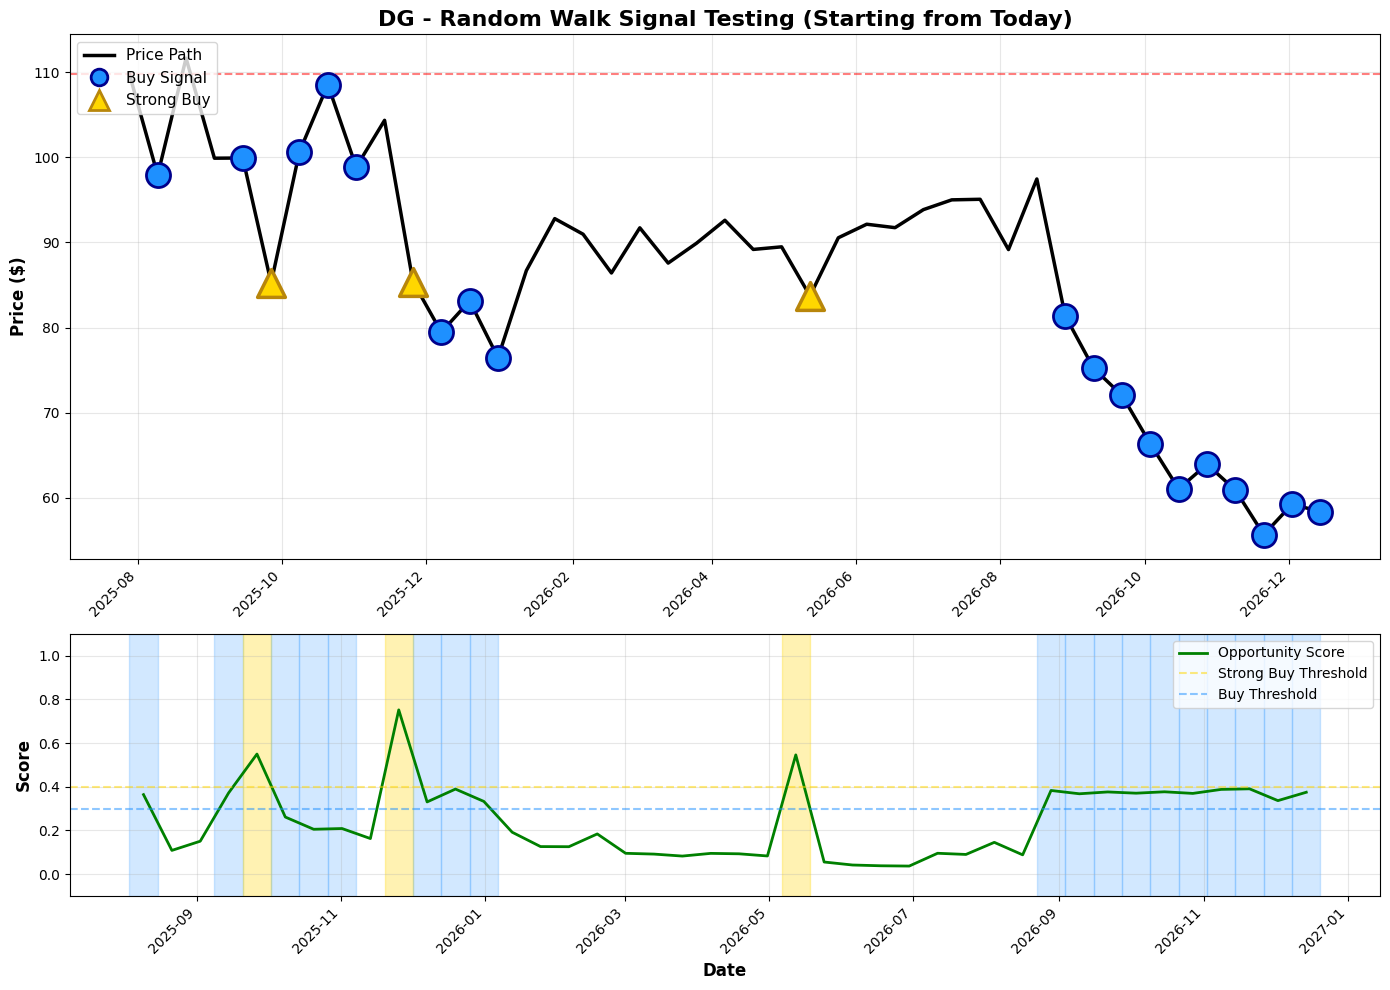


RANDOM WALK SIGNAL ANALYSIS

Starting Price: $109.83
Ending Price: $58.35
Price Change: -46.9%

Signals Generated:
  Buy Signals: 18
  Strong Buy Signals: 3
  Total Signals: 21

Signal Timing:
  2025-08-09: Buy at $97.91 (Score: 0.364, Position: 30.0%)
  2025-09-14: Buy at $99.93 (Score: 0.372, Position: 30.0%)
  2025-09-26: Strong Buy at $85.23 (Score: 0.550, Position: 50.0%)
  2025-10-08: Buy at $100.68 (Score: 0.261, Position: 30.0%)
  2025-10-20: Buy at $108.57 (Score: 0.205, Position: 10.0%)
  2025-11-01: Buy at $98.86 (Score: 0.209, Position: 10.0%)
  2025-11-25: Strong Buy at $85.40 (Score: 0.752, Position: 70.0%)
  2025-12-07: Buy at $79.45 (Score: 0.331, Position: 30.0%)
  2025-12-19: Buy at $83.12 (Score: 0.389, Position: 30.0%)
  2025-12-31: Buy at $76.45 (Score: 0.333, Position: 30.0%)
  2026-05-12: Strong Buy at $83.72 (Score: 0.546, Position: 50.0%)
  2026-08-28: Buy at $81.38 (Score: 0.383, Position: 30.0%)
  2026-09-09: Buy at $75.21 (Score: 0.368, Position: 30.0%)
  2

In [122]:
# RANDOM WALK SIMULATION
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Load the saved data

dollar_bars = pd.read_csv(f'{TICKER}_dollar_bars_adaptive_position_sizing.csv', 
                          index_col='Date', parse_dates=True)

print(f"\n{'='*60}")
print(f"RANDOM WALK SIMULATION - BUY SIGNAL TESTING")
print(f"{'='*60}")
print(f"Testing buy signal detection on random walk from today's price")

# GENERATE RANDOM WALK FROM TODAY

def generate_random_walk_with_signals(data, projection_bars=42):
    """
    Generate a single random walk starting from today's price
    Apply the full buy signal logic to see what signals are generated
    """
    # Get today's starting values
    current_price = data['Close'].iloc[-1]
    current_date = datetime.now()
    
    # Historical volatility for realistic movement
    returns = data['Returns'].dropna()
    daily_vol = returns.std() * 1.5  # Slightly higher vol for testing
    
    # Initialize tracking arrays
    prices = [current_price]
    dates = [current_date]
    
    # Technical indicators - start from recent values
    rsi_values = [data['RSI_14'].iloc[-1]]
    bb_positions = []
    local_low_scores = []
    opportunity_scores = []
    buy_signals = []
    strong_buy_signals = []
    position_sizes = []
    
    # Generate random walk
    price_history = list(data['Close'].iloc[-20:].values) + [current_price]
    
    for i in range(projection_bars):
        # Pure random walk - no drift, just volatility
        random_return = np.random.normal(0, daily_vol)
        new_price = prices[-1] * (1 + random_return)
        
        prices.append(new_price)
        dates.append(dates[-1] + timedelta(days=12))  # Approximate dollar bar duration
        price_history.append(new_price)
        
        # Calculate technical indicators on the random walk
        
        # RSI calculation (simplified but realistic)
        recent_changes = []
        for j in range(1, min(15, len(prices))):
            if j < len(prices):
                change = prices[-j] - prices[-j-1]
                recent_changes.append(change)
        
        if recent_changes:
            gains = [c for c in recent_changes if c > 0]
            losses = [-c for c in recent_changes if c < 0]
            
            avg_gain = np.mean(gains) if gains else 0
            avg_loss = np.mean(losses) if losses else 0
            
            if avg_loss > 0:
                rs = avg_gain / avg_loss
                new_rsi = 100 - (100 / (1 + rs))
            else:
                new_rsi = 100 if avg_gain > 0 else 50
        else:
            new_rsi = 50
        
        rsi_values.append(new_rsi)
        
        # Bollinger Bands calculation
        if len(price_history) >= 20:
            recent_20 = price_history[-20:]
            bb_mean = np.mean(recent_20)
            bb_std = np.std(recent_20)
            bb_upper = bb_mean + 2 * bb_std
            bb_lower = bb_mean - 2 * bb_std
            
            if bb_upper > bb_lower:
                new_bb_position = (new_price - bb_lower) / (bb_upper - bb_lower)
            else:
                new_bb_position = 0.5
        else:
            new_bb_position = 0.5
        
        bb_positions.append(new_bb_position)
        
        # Local low score calculation
        if len(prices) >= 10:
            recent_10 = prices[-10:]
            recent_min = min(recent_10)
            recent_max = max(recent_10)
            
            if recent_max > recent_min:
                distance_from_low = (new_price - recent_min) / (recent_max - recent_min)
                
                # High score when near recent lows
                if distance_from_low < 0.2:
                    new_local_low = 0.8
                elif distance_from_low < 0.3:
                    new_local_low = 0.6
                elif distance_from_low < 0.4:
                    new_local_low = 0.4
                else:
                    new_local_low = 0.2
            else:
                new_local_low = 0.3
        else:
            new_local_low = 0.3
        
        local_low_scores.append(new_local_low)
        
        # Calculate opportunity score (following original logic)
        score = 0
        
        # Local Low Score (35% weight)
        score += new_local_low * 0.35
        
        # RSI Score (25% weight) - oversold condition
        rsi_percentile = (100 - new_rsi) / 100
        if new_rsi < 30:
            rsi_score = 1.0
        elif new_rsi < 40:
            rsi_score = 0.7
        elif new_rsi < 50:
            rsi_score = 0.3
        else:
            rsi_score = 0
        score += rsi_score * 0.25
        
        # BB Score (20% weight) - near lower band
        if new_bb_position < 0.2:
            bb_score = 1.0
        elif new_bb_position < 0.3:
            bb_score = 0.7
        elif new_bb_position < 0.4:
            bb_score = 0.3
        else:
            bb_score = 0
        score += bb_score * 0.20
        
        # Trend component (10% weight) - simplified
        if len(prices) >= 5:
            trend = (new_price - prices[-5]) / prices[-5]
            if trend < -0.1:  # Down trend
                trend_score = 0.8
            elif trend < -0.05:
                trend_score = 0.5
            else:
                trend_score = 0
            score += trend_score * 0.10
        
        # Add some randomness (5% weight)
        score += np.random.uniform(0, 0.05)
        
        # Apply time spacing penalty
        if buy_signals and len(buy_signals) >= 10:
            recent_signals = sum(buy_signals[-10:])
            if recent_signals > 0:
                score *= 0.5  # Reduce score if recent signal
        
        new_opportunity = np.clip(score, 0, 1)
        opportunity_scores.append(new_opportunity)
        
        # Determine signals based on thresholds
        is_buy = new_opportunity > 0.20
        is_strong_buy = new_opportunity > 0.50
        
        buy_signals.append(is_buy)
        strong_buy_signals.append(is_strong_buy)
        
        # Calculate position size based on opportunity score
        if new_opportunity > 0.8:
            position_size = 1.0
        elif new_opportunity > 0.6:
            position_size = 0.7
        elif new_opportunity > 0.4:
            position_size = 0.5
        elif new_opportunity > 0.25:
            position_size = 0.3
        else:
            position_size = 0.1
        
        position_sizes.append(position_size)
    
    return {
        'prices': prices[1:],  # Exclude starting price
        'dates': dates[1:],    # Exclude starting date
        'rsi': rsi_values[1:],
        'bb_positions': bb_positions,
        'local_low_scores': local_low_scores,
        'opportunity_scores': opportunity_scores,
        'buy_signals': buy_signals,
        'strong_buy_signals': strong_buy_signals,
        'position_sizes': position_sizes
    }

# Generate random walk
print("\nGenerating random walk from today's price...")
random_walk = generate_random_walk_with_signals(dollar_bars, projection_bars=42)

# ===== VISUALIZATION =====
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), height_ratios=[2, 1])

# Top panel - Price and signals
start_price = dollar_bars['Close'].iloc[-1]
all_prices = [start_price] + random_walk['prices']
all_dates = [datetime.now()] + random_walk['dates']

# Plot price path
ax1.plot(all_dates, all_prices, 'k-', linewidth=2.5, label='Random Walk')

# Mark buy signals
for i, (date, signal, strong_signal) in enumerate(zip(random_walk['dates'], 
                                                      random_walk['buy_signals'], 
                                                      random_walk['strong_buy_signals'])):
    if strong_signal:
        ax1.scatter(date, random_walk['prices'][i], s=400, c='gold', marker='^', 
                   edgecolors='darkgoldenrod', linewidth=2.5, zorder=6)
    elif signal:
        ax1.scatter(date, random_walk['prices'][i], s=300, c='dodgerblue', marker='o', 
                   edgecolors='darkblue', linewidth=2, zorder=5)

# Reference line at starting price
ax1.axhline(y=start_price, color='red', linestyle='--', alpha=0.5, linewidth=1.5)

# Formatting
ax1.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
ax1.set_title(f'{TICKER} - Random Walk Signal Testing (Starting from Today)', fontsize=16, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='k', linewidth=2.5, label='Price Path'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='dodgerblue', 
           markersize=12, label='Buy Signal', markeredgecolor='darkblue', markeredgewidth=2),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='gold', 
           markersize=14, label='Strong Buy', markeredgecolor='darkgoldenrod', markeredgewidth=2)
]
ax1.legend(handles=legend_elements, loc='upper left', fontsize=11)

# Bottom panel - Technical indicators
ax2.plot(random_walk['dates'], random_walk['opportunity_scores'], 'g-', linewidth=2, label='Opportunity Score')
ax2.axhline(y=STRONG_BUY_THRESHOLD, color='gold', linestyle='--', alpha=0.5, label='Strong Buy Threshold')
ax2.axhline(y=BUY_THRESHOLD, color='dodgerblue', linestyle='--', alpha=0.5, label='Buy Threshold')

# Fill areas where signals occur
for i, (signal, strong_signal) in enumerate(zip(random_walk['buy_signals'], random_walk['strong_buy_signals'])):
    if strong_signal:
        ax2.axvspan(random_walk['dates'][i] - timedelta(days=6), 
                   random_walk['dates'][i] + timedelta(days=6), 
                   alpha=0.3, color='gold')
    elif signal:
        ax2.axvspan(random_walk['dates'][i] - timedelta(days=6), 
                   random_walk['dates'][i] + timedelta(days=6), 
                   alpha=0.2, color='dodgerblue')

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Score', fontsize=12, fontweight='bold')
ax2.set_ylim(-0.1, 1.1)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='upper right', fontsize=10)

# Date formatting
import matplotlib.dates as mdates
for ax in [ax1, ax2]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

# ===== SIGNAL ANALYSIS =====
print(f"\n{'='*50}")
print("RANDOM WALK SIGNAL ANALYSIS")
print(f"{'='*50}")

print(f"\nStarting Price: ${start_price:.2f}")
print(f"Ending Price: ${random_walk['prices'][-1]:.2f}")
print(f"Price Change: {((random_walk['prices'][-1] / start_price) - 1) * 100:.1f}%")

# Count signals
total_buy_signals = sum(random_walk['buy_signals'])
total_strong_signals = sum(random_walk['strong_buy_signals'])

print(f"\nSignals Generated:")
print(f"  Buy Signals: {total_buy_signals - total_strong_signals}")
print(f"  Strong Buy Signals: {total_strong_signals}")
print(f"  Total Signals: {total_buy_signals}")

# Analyze signal distribution
if total_buy_signals > 0:
    print(f"\nSignal Timing:")
    for i, (date, signal, strong) in enumerate(zip(random_walk['dates'], 
                                                   random_walk['buy_signals'], 
                                                   random_walk['strong_buy_signals'])):
        if signal:
            signal_type = "Strong Buy" if strong else "Buy"
            price = random_walk['prices'][i]
            score = random_walk['opportunity_scores'][i]
            position = random_walk['position_sizes'][i]
            print(f"  {date.strftime('%Y-%m-%d')}: {signal_type} at ${price:.2f} "
                  f"(Score: {score:.3f}, Position: {position:.1%})")

# Technical indicator ranges
print(f"\nIndicator Ranges During Random Walk:")
print(f"  RSI: {min(random_walk['rsi']):.1f} - {max(random_walk['rsi']):.1f}")
print(f"  BB Position: {min(random_walk['bb_positions']):.2f} - {max(random_walk['bb_positions']):.2f}")
print(f"  Local Low Score: {min(random_walk['local_low_scores']):.2f} - {max(random_walk['local_low_scores']):.2f}")

print(f"\n{'='*50}")
print("ANALYSIS COMPLETE!")
print(f"{'='*50}")

Feautre selection


FEATURE SELECTION FOR POSITION SIZING MODEL
Analyzing 248 dollar bars

Feature Matrix Shape: (40, 17)
Number of buy signals analyzed: 40

Available features (17):
   1. Returns
   2. Log_Returns
   3. RSI_14
   4. RSI_Percentile
   5. BB_Position
   6. BB_Percentile
   7. Local_Low_Score
   8. SMA_20
   9. SMA_50
  10. SMA_200
  11. Price_to_SMA20
  12. Price_to_SMA50
  13. Price_to_SMA200
  14. Days_Since_High
  15. Days_Since_Low
  16. Drawdown
  17. Drawdown_Percentile

1. RANDOM FOREST FEATURE IMPORTANCE

Top 10 Most Important Features (Random Forest):
  RSI_14                   : 0.3065
  Price_to_SMA50           : 0.1154
  BB_Position              : 0.0906
  BB_Percentile            : 0.0826
  RSI_Percentile           : 0.0600
  Returns                  : 0.0574
  Price_to_SMA20           : 0.0515
  SMA_50                   : 0.0488
  Log_Returns              : 0.0370
  Local_Low_Score          : 0.0336

2. MUTUAL INFORMATION SCORES

Top 10 Features by Mutual Information:
  RSI_

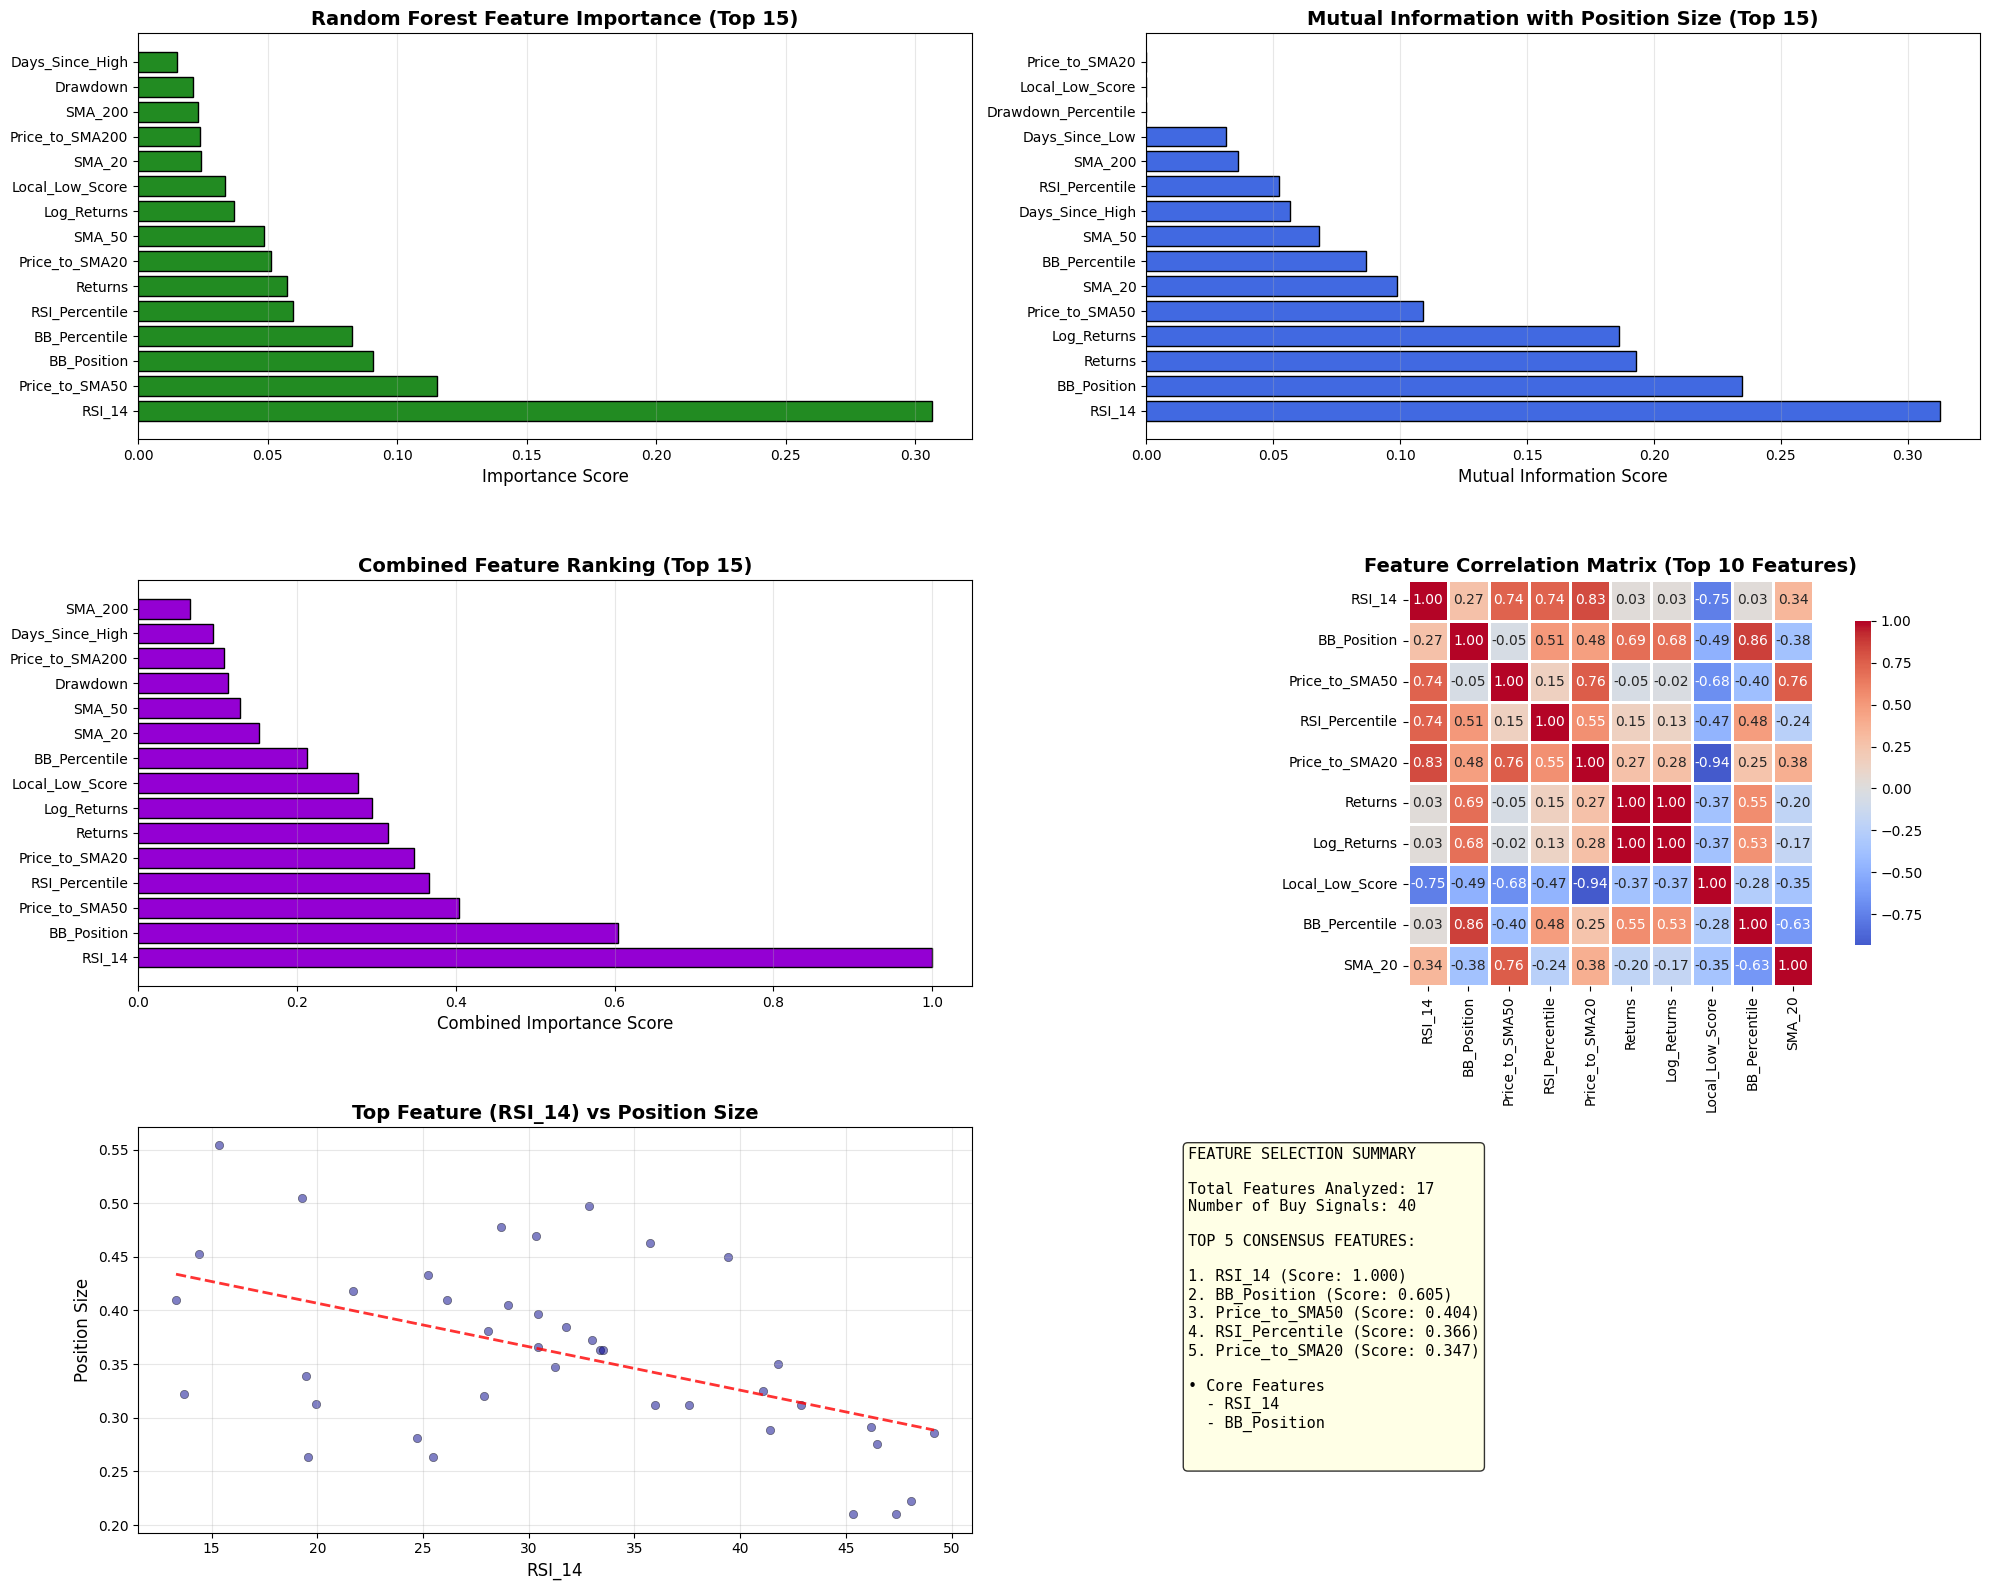


5. FEATURE REDUNDANCY ANALYSIS

Highly Correlated Feature Pairs (|correlation| > 0.8):
  RSI_14 <-> Price_to_SMA20: 0.825
  BB_Position <-> BB_Percentile: 0.860
  Price_to_SMA20 <-> Local_Low_Score: -0.935
  Returns <-> Log_Returns: 0.997


In [2]:
# FEATURE SELECTION FOR LONG-TERM POSITION SIZING 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression, SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Load the saved data
dollar_bars = pd.read_csv(f'{TICKER}_dollar_bars_adaptive_position_sizing.csv', 
                          index_col='Date', parse_dates=True)

print(f"\n{'='*60}")
print(f"FEATURE SELECTION FOR POSITION SIZING MODEL")
print(f"{'='*60}")

print(f"Analyzing {len(dollar_bars)} dollar bars")

# PREPARE FEATURES AND TARGET 

# Define all potential features
feature_columns = [
    # Price-based features
    'Returns', 'Log_Returns', 'Close_to_High', 'Close_to_Low',
    
    # Technical indicators
    'RSI_14', 'RSI_Percentile',
    'BB_Position', 'BB_Percentile',
    'Local_Low_Score',
    
    # Moving averages and trends
    'SMA_20', 'SMA_50', 'SMA_200',
    'Price_to_SMA20', 'Price_to_SMA50', 'Price_to_SMA200',
    
    # Volatility features
    'ATR_14', 'ATR_Percentile', 'Rolling_Volatility',
    
    # Volume features (if available in your data)
    'Volume_Ratio',  # If you have volume data
    
    # Market structure
    'Days_Since_High', 'Days_Since_Low',
    'Drawdown', 'Drawdown_Percentile'
]

# Filter to only include features that exist in the data
available_features = [col for col in feature_columns if col in dollar_bars.columns]

# If some features are missing, create them
if 'Price_to_SMA20' not in dollar_bars.columns and 'SMA_20' in dollar_bars.columns:
    dollar_bars['Price_to_SMA20'] = dollar_bars['Close'] / dollar_bars['SMA_20']
if 'Price_to_SMA50' not in dollar_bars.columns and 'SMA_50' in dollar_bars.columns:
    dollar_bars['Price_to_SMA50'] = dollar_bars['Close'] / dollar_bars['SMA_50']
if 'Price_to_SMA200' not in dollar_bars.columns and 'SMA_200' in dollar_bars.columns:
    dollar_bars['Price_to_SMA200'] = dollar_bars['Close'] / dollar_bars['SMA_200']

# Create drawdown features if not present
if 'Drawdown' not in dollar_bars.columns:
    rolling_max = dollar_bars['Close'].expanding().max()
    dollar_bars['Drawdown'] = (dollar_bars['Close'] - rolling_max) / rolling_max
    dollar_bars['Drawdown_Percentile'] = dollar_bars['Drawdown'].rolling(252).rank(pct=True)

# Days since high/low
if 'Days_Since_High' not in dollar_bars.columns:
    dollar_bars['Days_Since_High'] = 0
    dollar_bars['Days_Since_Low'] = 0
    for i in range(1, len(dollar_bars)):
        if dollar_bars['Close'].iloc[i] >= dollar_bars['Close'].iloc[:i+1].max():
            dollar_bars.loc[dollar_bars.index[i], 'Days_Since_High'] = 0
        else:
            dollar_bars.loc[dollar_bars.index[i], 'Days_Since_High'] = dollar_bars['Days_Since_High'].iloc[i-1] + 1
            
        if dollar_bars['Close'].iloc[i] <= dollar_bars['Close'].iloc[:i+1].min():
            dollar_bars.loc[dollar_bars.index[i], 'Days_Since_Low'] = 0
        else:
            dollar_bars.loc[dollar_bars.index[i], 'Days_Since_Low'] = dollar_bars['Days_Since_Low'].iloc[i-1] + 1

# Update available features
available_features = [col for col in feature_columns if col in dollar_bars.columns]

# Target variable: Position Size (what we want to predict)
target = 'Position_Size_Smoothed'

# Create feature matrix and target vector
# Only use rows where we have signals
signal_data = dollar_bars[dollar_bars['Buy_Signal'] == 1].copy()

# Prepare features
X = signal_data[available_features].fillna(method='ffill').fillna(0)
y = signal_data[target]

# Remove any remaining NaN values
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Number of buy signals analyzed: {len(X)}")
print(f"\nAvailable features ({len(available_features)}):")
for i, feat in enumerate(available_features):
    print(f"  {i+1:2d}. {feat}")

# FEATURE IMPORTANCE ANALYSIS

# 1. Random Forest Feature Importance
print("\n" + "="*50)
print("1. RANDOM FOREST FEATURE IMPORTANCE")
print("="*50)

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# Get feature importances
rf_importances = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
for i, row in rf_importances.head(10).iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")

# 2. Mutual Information
print("\n" + "="*50)
print("2. MUTUAL INFORMATION SCORES")
print("="*50)

mi_scores = mutual_info_regression(X, y, random_state=42)
mi_importances = pd.DataFrame({
    'feature': X.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

print("\nTop 10 Features by Mutual Information:")
for i, row in mi_importances.head(10).iterrows():
    print(f"  {row['feature']:25s}: {row['mi_score']:.4f}")

# 3. F-statistic (ANOVA)
print("\n" + "="*50)
print("3. F-STATISTIC SCORES")
print("="*50)

f_selector = SelectKBest(f_regression, k='all')
f_selector.fit(X, y)

f_scores = pd.DataFrame({
    'feature': X.columns,
    'f_score': f_selector.scores_
}).sort_values('f_score', ascending=False)

print("\nTop 10 Features by F-statistic:")
for i, row in f_scores.head(10).iterrows():
    print(f"  {row['feature']:25s}: {row['f_score']:.2f}")

# ===== CORRELATION ANALYSIS =====
print("\n" + "="*50)
print("4. FEATURE CORRELATION ANALYSIS")
print("="*50)

# Calculate correlations with target
target_correlations = X.corrwith(y).abs().sort_values(ascending=False)

print("\nTop 10 Features by Correlation with Position Size:")
for feat, corr in target_correlations.head(10).items():
    print(f"  {feat:25s}: {corr:.4f}")

# ===== VISUALIZATION =====
fig = plt.figure(figsize=(20, 16))

# 1. Random Forest Feature Importance
ax1 = plt.subplot(3, 2, 1)
top_rf = rf_importances.head(15)
ax1.barh(range(len(top_rf)), top_rf['importance'], color='forestgreen', edgecolor='black')
ax1.set_yticks(range(len(top_rf)))
ax1.set_yticklabels(top_rf['feature'])
ax1.set_xlabel('Importance Score', fontsize=12)
ax1.set_title('Random Forest Feature Importance (Top 15)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# 2. Mutual Information Scores
ax2 = plt.subplot(3, 2, 2)
top_mi = mi_importances.head(15)
ax2.barh(range(len(top_mi)), top_mi['mi_score'], color='royalblue', edgecolor='black')
ax2.set_yticks(range(len(top_mi)))
ax2.set_yticklabels(top_mi['feature'])
ax2.set_xlabel('Mutual Information Score', fontsize=12)
ax2.set_title('Mutual Information with Position Size (Top 15)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 3. Combined Feature Ranking
ax3 = plt.subplot(3, 2, 3)
# Normalize scores to 0-1 range for comparison
rf_norm = (rf_importances.set_index('feature')['importance'] / rf_importances['importance'].max())
mi_norm = (mi_importances.set_index('feature')['mi_score'] / mi_importances['mi_score'].max())
f_norm = (f_scores.set_index('feature')['f_score'] / f_scores['f_score'].max())

# Calculate combined score
combined_scores = pd.DataFrame({
    'rf': rf_norm,
    'mi': mi_norm,
    'f': f_norm
}).fillna(0)
combined_scores['combined'] = combined_scores.mean(axis=1)
top_combined = combined_scores.sort_values('combined', ascending=False).head(15)

ax3.barh(range(len(top_combined)), top_combined['combined'], color='darkviolet', edgecolor='black')
ax3.set_yticks(range(len(top_combined)))
ax3.set_yticklabels(top_combined.index)
ax3.set_xlabel('Combined Importance Score', fontsize=12)
ax3.set_title('Combined Feature Ranking (Top 15)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

# 4. Feature Correlation Heatmap
ax4 = plt.subplot(3, 2, 4)
# Select top features for correlation matrix
top_features = list(top_combined.head(10).index)
corr_matrix = X[top_features].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": .8}, ax=ax4)
ax4.set_title('Feature Correlation Matrix (Top 10 Features)', fontsize=14, fontweight='bold')

# 5. Feature vs Target Scatter
ax5 = plt.subplot(3, 2, 5)
top_feature = top_combined.index[0]
ax5.scatter(X[top_feature], y, alpha=0.5, color='darkblue', edgecolors='black', linewidth=0.5)
ax5.set_xlabel(top_feature, fontsize=12)
ax5.set_ylabel('Position Size', fontsize=12)
ax5.set_title(f'Top Feature ({top_feature}) vs Position Size', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(X[top_feature], y, 1)
p = np.poly1d(z)
ax5.plot(sorted(X[top_feature]), p(sorted(X[top_feature])), "r--", alpha=0.8, linewidth=2)

# 6. Feature Selection Summary
ax6 = plt.subplot(3, 2, 6)
ax6.axis('off')

summary_text = f"""FEATURE SELECTION SUMMARY

Total Features Analyzed: {len(available_features)}
Number of Buy Signals: {len(X)}

TOP 5 CONSENSUS FEATURES:
"""

for i, (feat, score) in enumerate(top_combined.head(5).iterrows()):
    summary_text += f"\n{i+1}. {feat} (Score: {score['combined']:.3f})"

summary_text += f"""

• Core Features
  - {top_combined.index[0]}
  - {top_combined.index[1]}
  
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, 
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

# FEATURE REDUNDANCY CHECK
print("\n" + "="*50)
print("5. FEATURE REDUNDANCY ANALYSIS")
print("="*50)

# Find highly correlated feature pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nHighly Correlated Feature Pairs (|correlation| > 0.8):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated feature pairs found (good!)")


XGBOOST


POSITION SIZING MODEL TRAINING
Training models for long-term position sizing
Available features in dataset:
['Avg_High', 'Avg_Low', 'Bar_Duration_Days', 'Returns', 'Log_Returns', 'RSI_14', 'RSI_7', 'RSI_Percentile', 'ATR', 'ATR_Percent', 'BB_Upper', 'BB_Middle', 'BB_Lower', 'BB_Position', 'BB_Percentile', 'Stoch_K', 'Stoch_Percentile', 'Local_Low_Score_Short', 'Is_Local_Low_Short', 'Local_Low_Score_Medium', 'Is_Local_Low_Medium', 'Local_Low_Score_Long', 'Is_Local_Low_Long', 'Local_Low_Score', 'SMA_20', 'SMA_50', 'SMA_200', 'Distance_SMA20', 'Distance_SMA50', 'Distance_SMA200', 'Distance_SMA20_Adjusted', 'Distance_SMA50_Adjusted', 'Double_Bottom', 'Higher_Low', 'Opportunity_Score', 'Opportunity_Score_Spaced', 'Year', 'position_size_target', 'buy_signal']

Training Data Summary:
  Total buy signals: 40
  Date range: 2021-02-26 to 2025-02-03
  Features used: Local_Low_Score, Opportunity_Score_Spaced, RSI_Percentile, BB_Position, Distance_SMA20, ATR_Percent
  Target range: 0.210 to 0.554


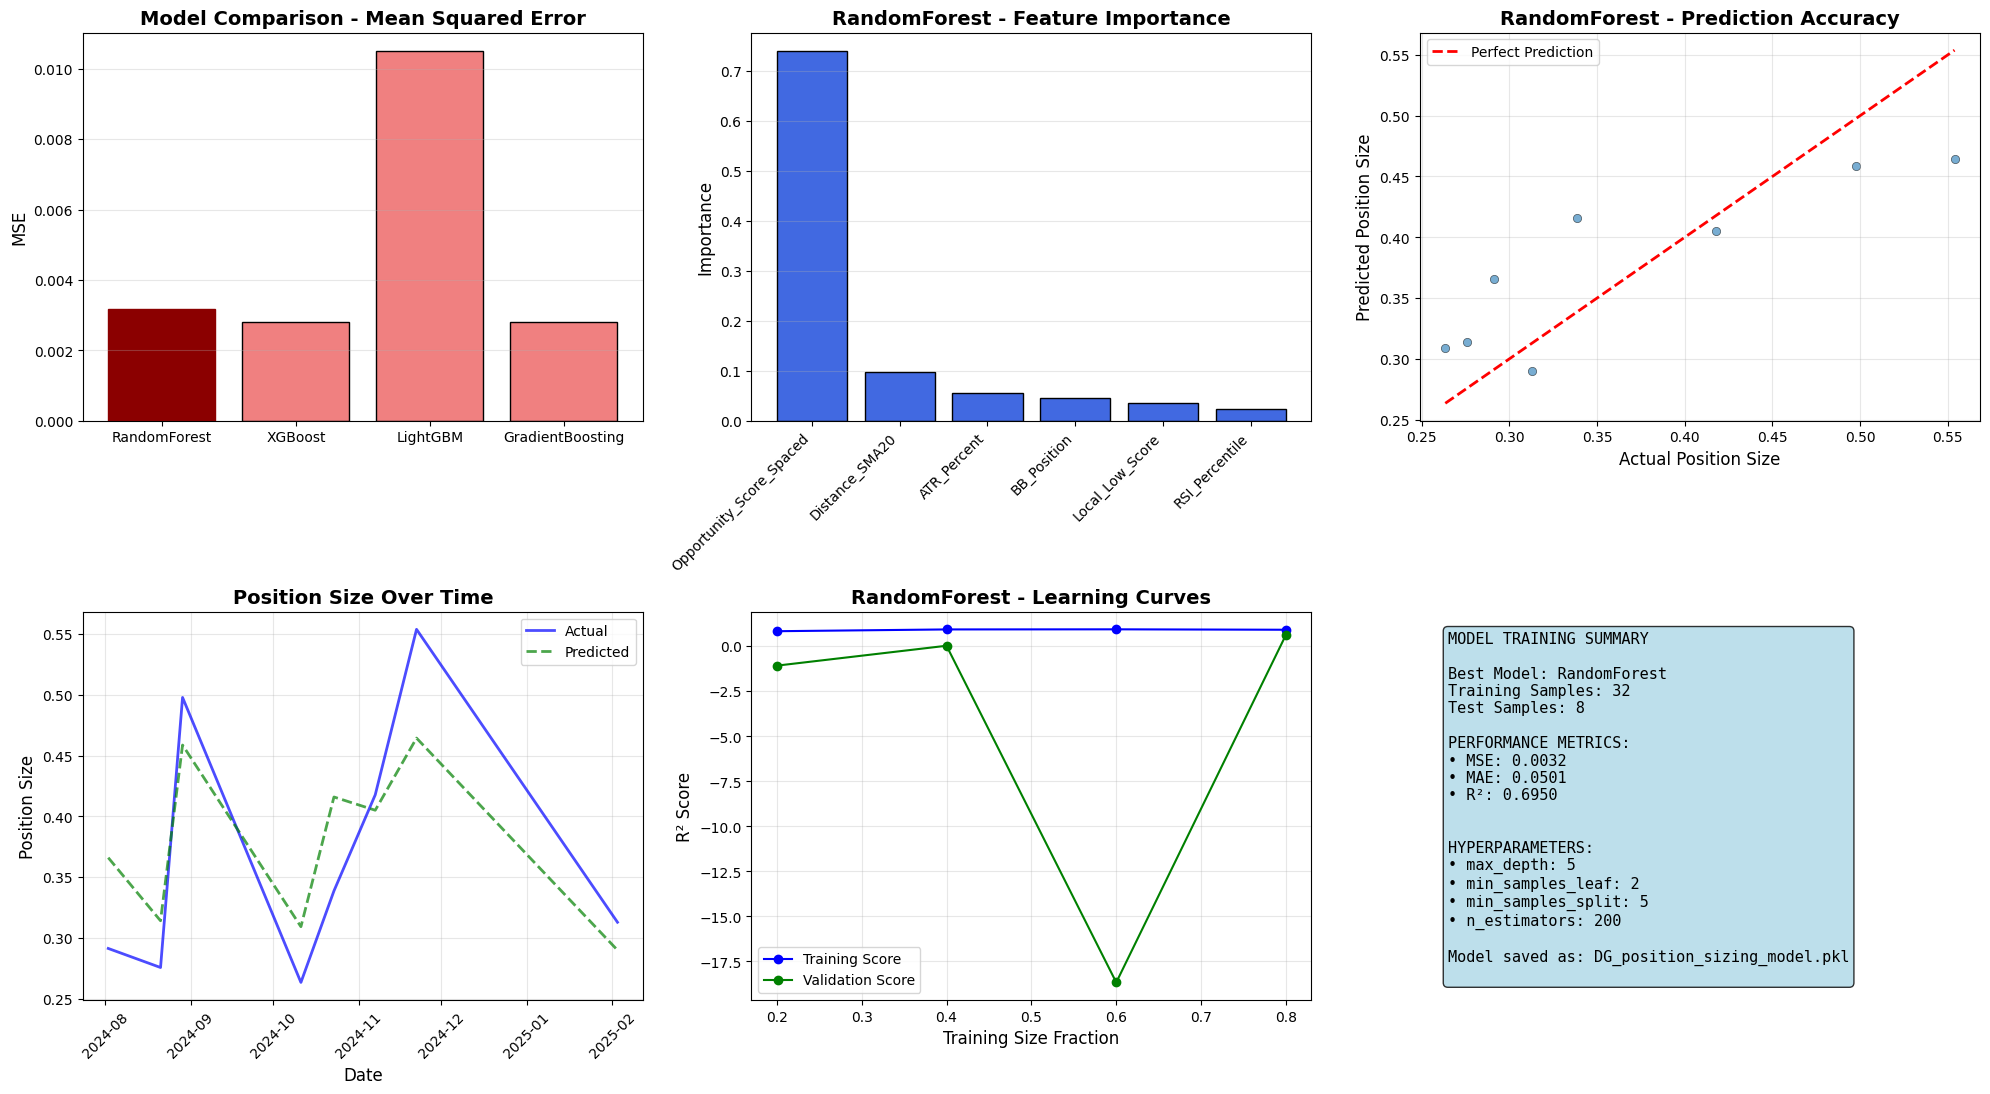


MODEL TRAINING COMPLETE!
Best model (RandomForest) saved to: DG_position_sizing_model.pkl


In [130]:
# MODEL TRAINING FOR POSITION SIZING
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

# Define selected features based on what's actually available
# Using features that exist in the dataset based on the feature selection analysis
SELECTED_FEATURES = [
    'Local_Low_Score',
    'Opportunity_Score_Spaced',
    'RSI_Percentile',
    'BB_Position',
    'Distance_SMA20',  # Using this instead of Drawdown
    'ATR_Percent'      # Using this instead of ATR_Percentile
]

# Load the saved data
dollar_bars = pd.read_csv(f'{TICKER}_dollar_bars_adaptive_position_sizing.csv', 
                          index_col='Date', parse_dates=True)

print(f"\n{'='*60}")
print(f"POSITION SIZING MODEL TRAINING")
print(f"{'='*60}")
print(f"Training models for long-term position sizing")

# FEATURE PREPARATION
# Check available features in the dataset
print("Available features in dataset:")
print([col for col in dollar_bars.columns if col not in ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 
                                                          'VWAP', 'Dollar_Volume', 'Trade_Count', 
                                                          'Buy_Signal', 'Strong_Buy_Signal', 
                                                          'Position_Size', 'Position_Size_Smoothed']])




# Target variable
TARGET = 'Position_Size_Smoothed'

# Prepare data - only use buy signals for training
signal_data = dollar_bars[dollar_bars['Buy_Signal'] == 1].copy()

# Create feature matrix and target
X = signal_data[SELECTED_FEATURES].copy()
y = signal_data[TARGET].copy()

# Remove any NaN values
mask = ~(X.isna().any(axis=1) | y.isna())
X = X[mask]
y = y[mask]

# Add date index for time series split
dates = signal_data.index[mask]

print(f"\nTraining Data Summary:")
print(f"  Total buy signals: {len(X)}")
print(f"  Date range: {dates[0].strftime('%Y-%m-%d')} to {dates[-1].strftime('%Y-%m-%d')}")
print(f"  Features used: {', '.join(SELECTED_FEATURES)}")
print(f"  Target range: {y.min():.3f} to {y.max():.3f}")

# CALCULATE FUTURE RETURNS FOR EVALUATION 

# Calculate actual forward returns for each signal
forward_returns = []
lookahead_years = 2

for idx in signal_data.index[mask]:
    signal_date = idx
    future_date = signal_date + DateOffset(years=lookahead_years)
    
    # Find the closest date in dollar_bars after or equal to future_date
    future_idx = dollar_bars.index.searchsorted(future_date)
    if future_idx < len(dollar_bars):
        future_pos = future_idx
        pos = dollar_bars.index.get_loc(signal_date)
        if future_pos > pos:
            future_return = (dollar_bars.iloc[future_pos]['Close'] /
                             dollar_bars.iloc[pos]['Close'] - 1)
        else:
            future_return = 0
    else:
        future_return = 0
    
    forward_returns.append(future_return)

forward_returns = np.array(forward_returns)

# ===== MODEL DEFINITIONS =====
models = {
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10, 15],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.05, 0.1],
            'num_leaves': [31, 50]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.8, 1.0]
        }
    }
}

# TIME SERIES CROSS-VALIDATION
# Use TimeSeriesSplit for proper temporal validation
tscv = TimeSeriesSplit(n_splits=5, test_size=None)

print("\n" + "="*50)
print("TRAINING MODELS WITH CROSS-VALIDATION")
print("="*50)

results = {}

for name, config in models.items():
    print(f"\nTraining {name}...")
    
    # Grid search with time series CV
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    
    # Fit model
    grid_search.fit(X, y)
    
    # Store results
    results[name] = {
        'best_model': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'best_score': -grid_search.best_score_,  # Convert back to positive MSE
        'cv_results': grid_search.cv_results_
    }
    
    print(f"  Best MSE: {results[name]['best_score']:.4f}")
    print(f"  Best params: {results[name]['best_params']}")

# ===== MODEL EVALUATION =====
print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

# Evaluate each model on hold-out test set
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
returns_test = forward_returns[train_size:]

evaluation_results = {}

for name, result in results.items():
    model = result['best_model']
    
    # Retrain on training set
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    
    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Position-weighted returns
    actual_returns = returns_test * y_test
    predicted_returns = returns_test * y_pred
    
    # Sharpe ratio (simplified)
    if len(actual_returns) > 0 and np.std(predicted_returns) > 0:
        sharpe_actual = np.mean(actual_returns) / np.std(actual_returns) * np.sqrt(252/21)
        sharpe_predicted = np.mean(predicted_returns) / np.std(predicted_returns) * np.sqrt(252/21)
    else:
        sharpe_actual = 0
        sharpe_predicted = 0
    
    evaluation_results[name] = {
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'mean_return_actual': np.mean(actual_returns),
        'mean_return_predicted': np.mean(predicted_returns),
        'sharpe_actual': sharpe_actual,
        'sharpe_predicted': sharpe_predicted,
        'predictions': y_pred
    }
    
    print(f"\n{name} Performance:")
    print(f"  MSE: {mse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  R²: {r2:.4f}")
    print(f"  Mean Return (actual sizing): {np.mean(actual_returns)*100:.2f}%")
    print(f"  Mean Return (predicted sizing): {np.mean(predicted_returns)*100:.2f}%")
    print(f"  Sharpe Ratio Improvement: {sharpe_predicted - sharpe_actual:.3f}")

# SELECT BEST MODEL 
# Choose based on Sharpe ratio improvement
best_model_name = max(evaluation_results.keys(), 
                     key=lambda x: evaluation_results[x]['sharpe_predicted'])
best_model = results[best_model_name]['best_model']

print(f"\n{'='*50}")
print(f"BEST MODEL: {best_model_name}")
print(f"{'='*50}")

# ===== VISUALIZATION =====
fig = plt.figure(figsize=(20, 16))

# 1. Model Comparison - MSE
ax1 = plt.subplot(3, 3, 1)
model_names = list(evaluation_results.keys())
mse_scores = [evaluation_results[name]['mse'] for name in model_names]

bars = ax1.bar(model_names, mse_scores, color='lightcoral', edgecolor='black')
ax1.set_ylabel('MSE', fontsize=12)
ax1.set_title('Model Comparison - Mean Squared Error', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Highlight best
best_idx = model_names.index(best_model_name)
bars[best_idx].set_color('darkred')


# 2. Feature Importance (Best Model)
ax2 = plt.subplot(3, 3, 2)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]

    ax2.bar(range(len(importances)), importances[indices],
            color='royalblue', edgecolor='black')
    ax2.set_xticks(range(len(importances)))
    ax2.set_xticklabels([SELECTED_FEATURES[i] for i in indices], rotation=45, ha='right')
    ax2.set_ylabel('Importance', fontsize=12)
    ax2.set_title(f'{best_model_name} - Feature Importance', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

# 3. Actual vs Predicted Position Sizes
ax3 = plt.subplot(3, 3, 3)
ax3.scatter(y_test, evaluation_results[best_model_name]['predictions'], 
           alpha=0.6, edgecolors='black', linewidth=0.5)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', linewidth=2, label='Perfect Prediction')
ax3.set_xlabel('Actual Position Size', fontsize=12)
ax3.set_ylabel('Predicted Position Size', fontsize=12)
ax3.set_title(f'{best_model_name} - Prediction Accuracy', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)


# 4. Position Size Over Time
ax4 = plt.subplot(3, 3, 4)
test_dates = dates[train_size:]
ax4.plot(test_dates, y_test, 'b-', linewidth=2, label='Actual', alpha=0.7)
ax4.plot(test_dates, evaluation_results[best_model_name]['predictions'], 
         'g--', linewidth=2, label='Predicted', alpha=0.7)
ax4.set_xlabel('Date', fontsize=12)
ax4.set_ylabel('Position Size', fontsize=12)
ax4.set_title('Position Size Over Time', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# 5. Learning Curves
ax5 = plt.subplot(3, 3, 5)
train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
train_scores = []
val_scores = []

for train_size in train_sizes:
    size = int(train_size * len(X_train))
    if size > 10:  # Minimum size
        X_subset = X_train[:size]
        y_subset = y_train[:size]
        
        # Simple train/val split
        val_size = int(0.2 * size)
        X_t, X_v = X_subset[:-val_size], X_subset[-val_size:]
        y_t, y_v = y_subset[:-val_size], y_subset[-val_size:]
        
        if len(X_t) > 0 and len(X_v) > 0:
            best_model.fit(X_t, y_t)
            train_scores.append(best_model.score(X_t, y_t))
            val_scores.append(best_model.score(X_v, y_v))

ax5.plot(train_sizes[:len(train_scores)], train_scores, 'b-o', label='Training Score')
ax5.plot(train_sizes[:len(val_scores)], val_scores, 'g-o', label='Validation Score')
ax5.set_xlabel('Training Size Fraction', fontsize=12)
ax5.set_ylabel('R² Score', fontsize=12)
ax5.set_title(f'{best_model_name} - Learning Curves', fontsize=14, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Model Summary
ax6 = plt.subplot(3, 3, 6)
ax6.axis('off')

summary_text = f"""MODEL TRAINING SUMMARY

Best Model: {best_model_name}
Training Samples: {len(X_train)}
Test Samples: {len(X_test)}

PERFORMANCE METRICS:
• MSE: {evaluation_results[best_model_name]['mse']:.4f}
• MAE: {evaluation_results[best_model_name]['mae']:.4f}
• R²: {evaluation_results[best_model_name]['r2']:.4f}


HYPERPARAMETERS:
{chr(10).join([f'• {k}: {v}' for k, v in results[best_model_name]['best_params'].items()])}

Model saved as: {TICKER}_position_sizing_model.pkl
"""

ax6.text(0.05, 0.95, summary_text, transform=ax6.transAxes, 
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

plt.tight_layout()
plt.show()

# SAVE BEST MODEL 
# Retrain on full dataset
best_model.fit(X, y)

# Save model and configuration
model_package = {
    'model': best_model,
    'model_name': best_model_name,
    'features': SELECTED_FEATURES,
    'target': TARGET,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'performance_metrics': evaluation_results[best_model_name],
    'hyperparameters': results[best_model_name]['best_params']
}

model_filename = f'{TICKER}_position_sizing_model.pkl'
joblib.dump(model_package, model_filename)

print(f"\n{'='*50}")
print("MODEL TRAINING COMPLETE!")
print(f"{'='*50}")
print(f"Best model ({best_model_name}) saved to: {model_filename}")


Backtesting 


LONG-TERM BUY & HOLD BACKTEST
Backtesting DG with RandomForest model

Backtest Configuration:
  Initial Capital: $100,000
  In-Sample Period: 2015-01-15 to 2021-12-31
  Out-of-Sample Period: 2022-01-11 to 2025-07-22

Running backtests...
  - In-sample manual sizing...
  - In-sample model sizing...
  - Out-of-sample manual sizing...
  - Out-of-sample model sizing...


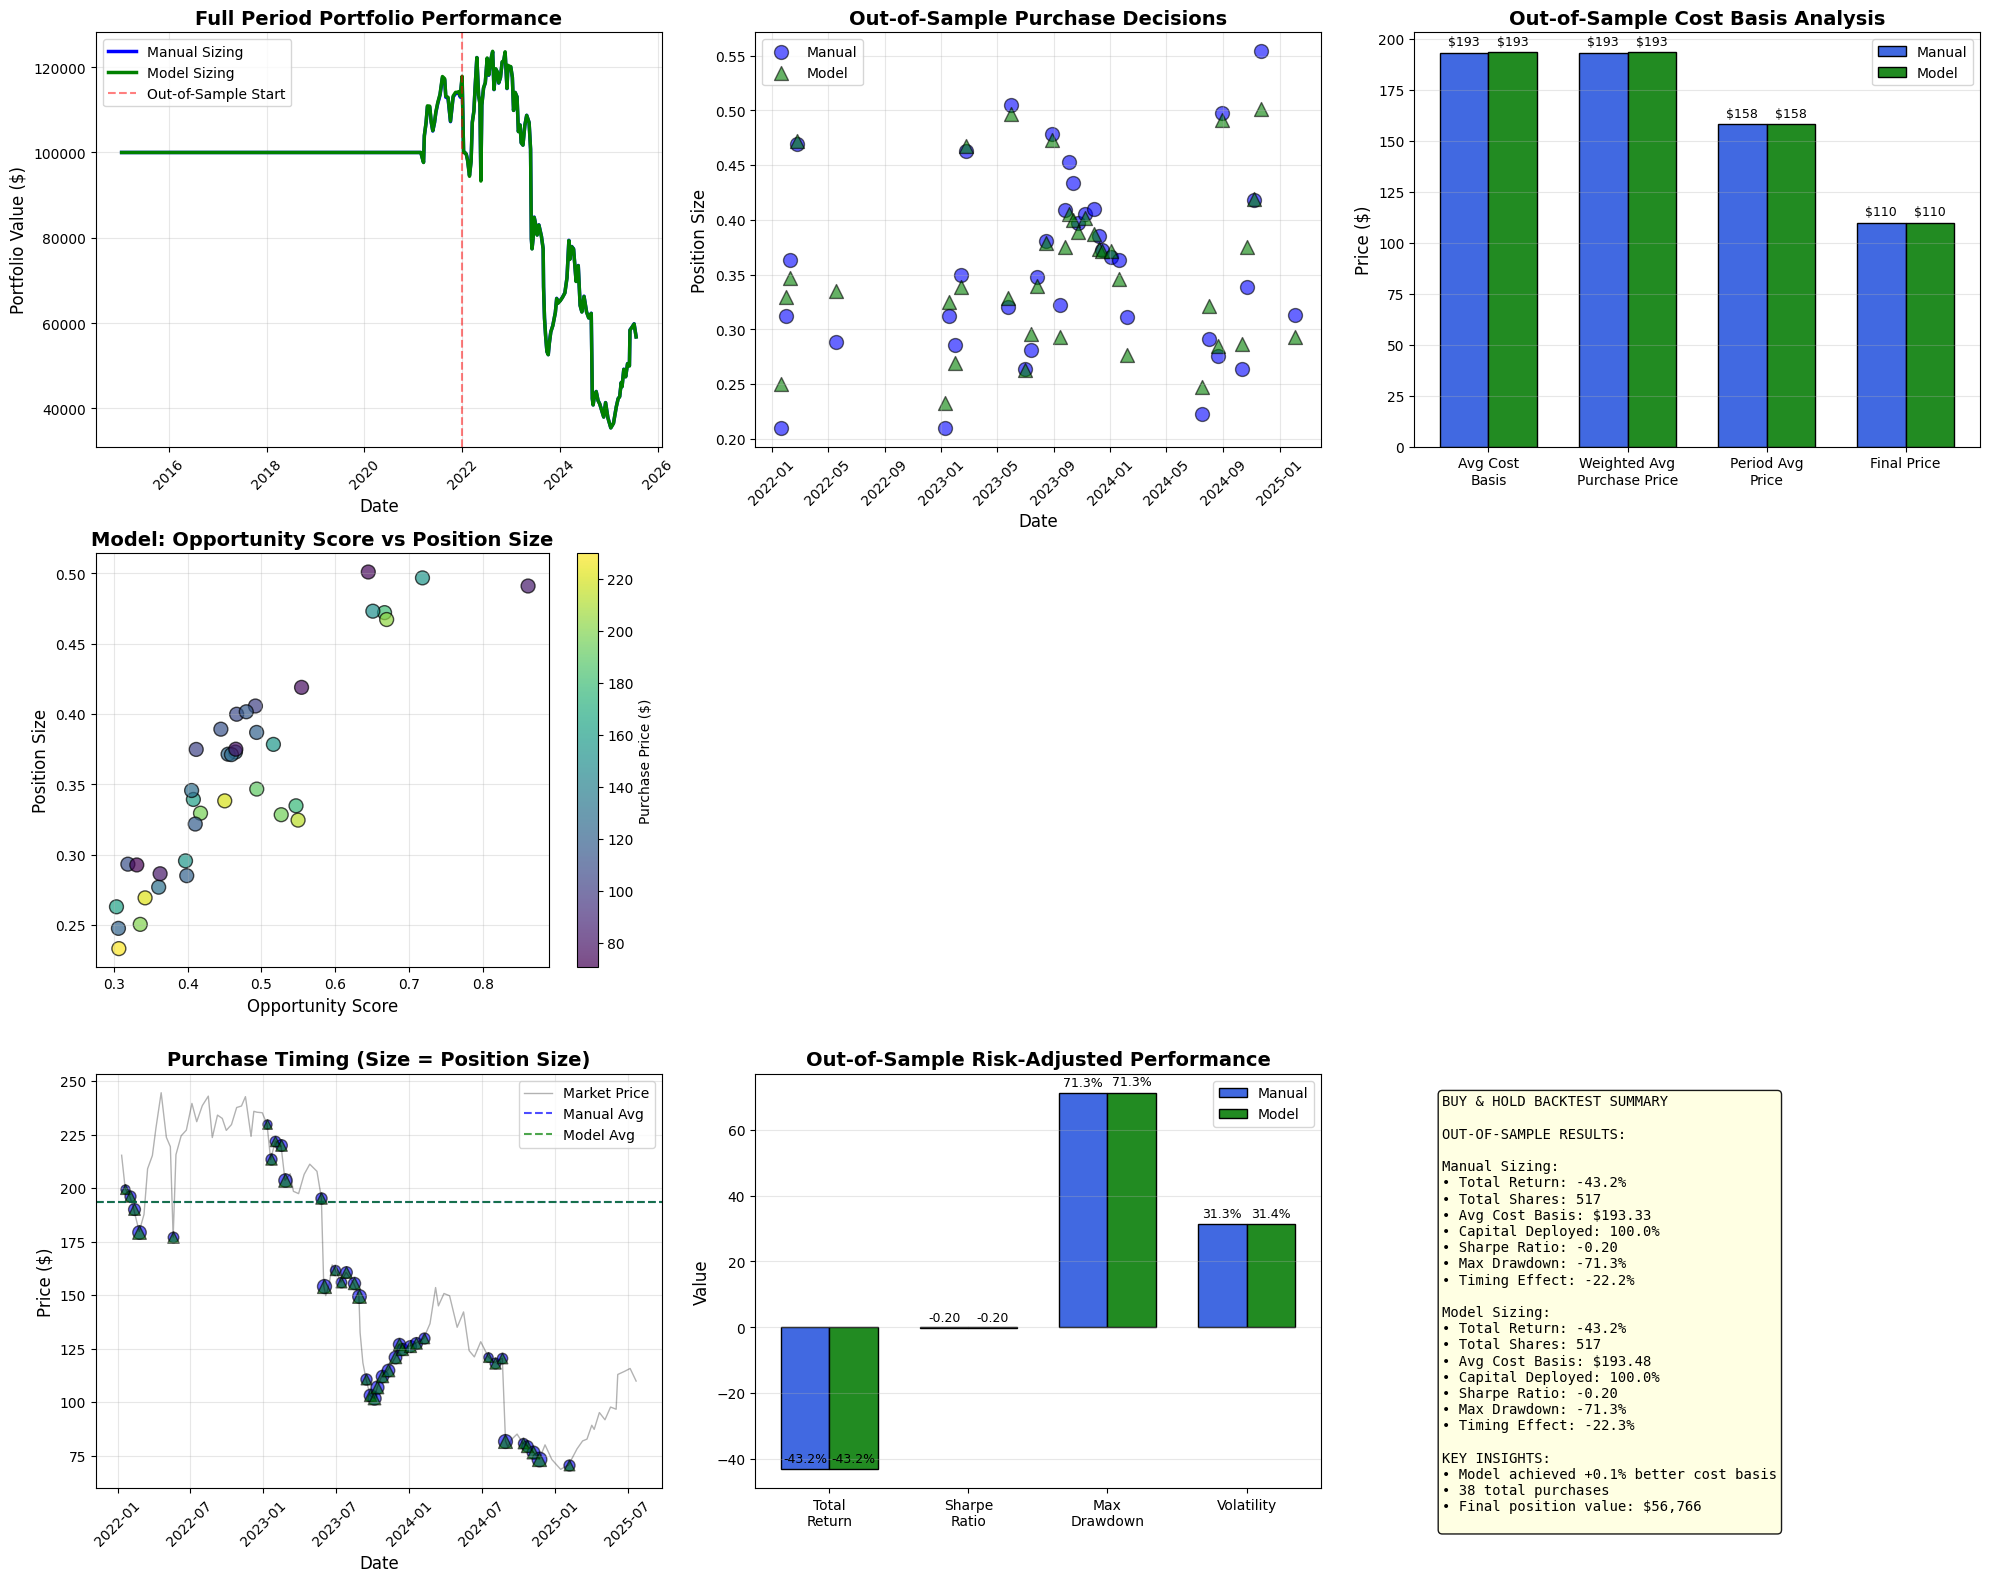


LONG-TERM HOLDING ANALYSIS

DOLLAR-COST AVERAGING PERFORMANCE:

Manual Strategy:
  Number of Purchases: 38
  Average Purchase Price: $141.97
  Weighted Average Price: $193.33
  Period Average Price: $158.17
  Timing Effectiveness: -22.2% worse than random
  Strong Buy Signals: 27 (avg price: $140.44)
  Regular Buy Signals: 11 (avg price: $145.73)

Model Strategy:
  Number of Purchases: 38
  Average Purchase Price: $141.97
  Weighted Average Price: $193.48
  Period Average Price: $158.17
  Timing Effectiveness: -22.3% worse than random
  Strong Buy Signals: 27 (avg price: $140.44)
  Regular Buy Signals: 11 (avg price: $145.73)

FINAL POSITION ANALYSIS:

Manual Strategy:
  Total Shares Owned: 517
  Position Value: $56,810.86
  Unrealized Gain: $-43,189.13
  Unrealized Gain %: -43.2%

Model Strategy:
  Total Shares Owned: 517
  Position Value: $56,765.68
  Unrealized Gain: $-43,234.31
  Unrealized Gain %: -43.2%

BACKTEST COMPLETE!

Results saved to: DG_buyhold_backtest_results.pkl


In [131]:
# MANUAL VS MODEL POSITION SIZING 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

INITIAL_CAPITAL = 100000
split_date = '2022-01-01'
# Load the saved data and model

dollar_bars = pd.read_csv(f'{TICKER}_dollar_bars_adaptive_position_sizing.csv', 
                          index_col='Date', parse_dates=True)

# Load the trained model
model_package = joblib.load(f'{TICKER}_position_sizing_model.pkl')
model = model_package['model']
features = model_package['features']

print(f"\n{'='*60}")
print(f"LONG-TERM BUY & HOLD BACKTEST")
print(f"{'='*60}")
print(f"Backtesting {TICKER} with {model_package['model_name']} model")



# Split data for in-sample and out-of-sample testing
in_sample_data = dollar_bars[dollar_bars.index < split_date].copy()
out_sample_data = dollar_bars[dollar_bars.index >= split_date].copy()

# Handle NaN values
if in_sample_data.isna().any().any():
    in_sample_data = in_sample_data.fillna(method='ffill').fillna(method='bfill')
    
if out_sample_data.isna().any().any():
    out_sample_data = out_sample_data.fillna(method='ffill').fillna(method='bfill')

print(f"\nBacktest Configuration:")
print(f"  Initial Capital: ${INITIAL_CAPITAL:,}")
print(f"  In-Sample Period: {in_sample_data.index[0].strftime('%Y-%m-%d')} to {in_sample_data.index[-1].strftime('%Y-%m-%d')}")
print(f"  Out-of-Sample Period: {out_sample_data.index[0].strftime('%Y-%m-%d')} to {out_sample_data.index[-1].strftime('%Y-%m-%d')}")

# BACKTEST FUNCTIONS 
def run_buy_and_hold_backtest(data, position_size_column, model_positions=False):
    """
    Run buy & hold backtest with given position sizing strategy
    """
    # Initialize tracking
    cash = INITIAL_CAPITAL
    holdings = {}  # Dictionary of {entry_price: {'shares': X, 'cost': Y, 'date': Z}}
    portfolio_values = []
    dates = []
    
    # Track purchases
    total_invested = 0
    purchases = []
    
    # Track metrics
    cumulative_shares = 0
    average_cost_basis = 0
    
    for i, (date, row) in enumerate(data.iterrows()):
        # Check for buy signals
        if row['Buy_Signal'] == 1 and cash > 0:
            # Determine position size
            if model_positions:
                # Use model to predict position size
                feature_values = row[features].values.reshape(1, -1)
                position_size = model.predict(feature_values)[0]
                position_size = np.clip(position_size, 0.1, 1.0)
            else:
                position_size = row[position_size_column]
            
            # Calculate investment amount
            invest_amount = min(cash * position_size, cash)
            
            # Buy shares
            shares = invest_amount / row['Close']
            
            # Record purchase
            purchase = {
                'date': date,
                'price': row['Close'],
                'shares': shares,
                'amount': invest_amount,
                'position_size': position_size,
                'is_strong_buy': row['Strong_Buy_Signal'] == 1,
                'opportunity_score': row['Opportunity_Score_Spaced']
            }
            purchases.append(purchase)
            
            # Update holdings
            cumulative_shares += shares
            total_invested += invest_amount
            cash -= invest_amount
            
            # Update average cost basis
            if cumulative_shares > 0:
                average_cost_basis = total_invested / cumulative_shares
        
        # Calculate portfolio value
        current_value = cumulative_shares * row['Close'] + cash
        portfolio_values.append(current_value)
        dates.append(date)
    
    # Final calculations
    final_price = data.iloc[-1]['Close']
    final_value = cumulative_shares * final_price + cash
    total_return = (final_value - INITIAL_CAPITAL) / INITIAL_CAPITAL
    
    # Calculate dollar-cost averaging metrics
    purchases_df = pd.DataFrame(purchases)
    if len(purchases_df) > 0:
        avg_purchase_price = purchases_df['price'].mean()
        weighted_avg_price = (purchases_df['price'] * purchases_df['shares']).sum() / purchases_df['shares'].sum()
        
        # Calculate timing effectiveness
        # Compare weighted average purchase price to simple average of all prices during period
        period_avg_price = data['Close'].mean()
        timing_effectiveness = (period_avg_price - weighted_avg_price) / period_avg_price
    else:
        avg_purchase_price = 0
        weighted_avg_price = 0
        timing_effectiveness = 0
    
    # Calculate returns series for risk metrics
    returns_series = pd.Series(portfolio_values).pct_change().dropna()
    
    if len(returns_series) > 0:
        sharpe_ratio = returns_series.mean() / returns_series.std() * np.sqrt(252/12)
        volatility = returns_series.std() * np.sqrt(252/12)
        
        # Calculate max drawdown
        cumulative = (1 + returns_series).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
    else:
        sharpe_ratio = 0
        volatility = 0
        max_drawdown = 0
    
    results = {
        'portfolio_values': portfolio_values,
        'dates': dates,
        'purchases': purchases_df,
        'final_value': final_value,
        'total_return': total_return,
        'sharpe_ratio': sharpe_ratio,
        'volatility': volatility,
        'max_drawdown': max_drawdown,
        'total_shares': cumulative_shares,
        'average_cost_basis': average_cost_basis,
        'final_price': final_price,
        'total_invested': total_invested,
        'cash_remaining': cash,
        'avg_purchase_price': avg_purchase_price,
        'weighted_avg_price': weighted_avg_price,
        'timing_effectiveness': timing_effectiveness
    }
    
    return results

# ===== RUN BACKTESTS =====
print("\nRunning backtests...")

# In-sample backtests
print("  - In-sample manual sizing...")
manual_results_is = run_buy_and_hold_backtest(in_sample_data, 'Position_Size_Smoothed', model_positions=False)

print("  - In-sample model sizing...")
model_results_is = run_buy_and_hold_backtest(in_sample_data, None, model_positions=True)

# Out-of-sample backtests
print("  - Out-of-sample manual sizing...")
manual_results_oos = run_buy_and_hold_backtest(out_sample_data, 'Position_Size_Smoothed', model_positions=False)

print("  - Out-of-sample model sizing...")
model_results_oos = run_buy_and_hold_backtest(out_sample_data, None, model_positions=True)

# ===== VISUALIZATION =====
fig = plt.figure(figsize=(20, 16))

# 1. Portfolio Value Comparison (Full Period)
ax1 = plt.subplot(3, 3, 1)
# Combine in-sample and out-of-sample for full picture
all_dates_manual = manual_results_is['dates'] + manual_results_oos['dates']
all_values_manual = manual_results_is['portfolio_values'] + manual_results_oos['portfolio_values']
all_dates_model = model_results_is['dates'] + model_results_oos['dates']
all_values_model = model_results_is['portfolio_values'] + model_results_oos['portfolio_values']

ax1.plot(all_dates_manual, all_values_manual, 'b-', linewidth=2.5, label='Manual Sizing')
ax1.plot(all_dates_model, all_values_model, 'g-', linewidth=2.5, label='Model Sizing')
ax1.axvline(x=pd.to_datetime(split_date), color='red', linestyle='--', alpha=0.5, label='Out-of-Sample Start')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Portfolio Value ($)', fontsize=12)
ax1.set_title('Full Period Portfolio Performance', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# 2. Purchase Analysis
ax2 = plt.subplot(3, 3, 2)
# Show when purchases were made and at what size
if len(manual_results_oos['purchases']) > 0 and len(model_results_oos['purchases']) > 0:
    ax2.scatter(manual_results_oos['purchases']['date'], 
               manual_results_oos['purchases']['position_size'], 
               s=100, alpha=0.6, label='Manual', color='blue', edgecolors='black')
    ax2.scatter(model_results_oos['purchases']['date'], 
               model_results_oos['purchases']['position_size'], 
               s=100, alpha=0.6, label='Model', color='green', marker='^', edgecolors='black')
    
    ax2.set_xlabel('Date', fontsize=12)
    ax2.set_ylabel('Position Size', fontsize=12)
    ax2.set_title('Out-of-Sample Purchase Decisions', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

# 3. Cost Basis Analysis
ax3 = plt.subplot(3, 3, 3)
metrics = ['Avg Cost\nBasis', 'Weighted Avg\nPurchase Price', 'Period Avg\nPrice', 'Final Price']
manual_prices = [
    manual_results_oos['average_cost_basis'],
    manual_results_oos['weighted_avg_price'],
    out_sample_data['Close'].mean(),
    manual_results_oos['final_price']
]
model_prices = [
    model_results_oos['average_cost_basis'],
    model_results_oos['weighted_avg_price'],
    out_sample_data['Close'].mean(),
    model_results_oos['final_price']
]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax3.bar(x - width/2, manual_prices, width, label='Manual', color='royalblue', edgecolor='black')
bars2 = ax3.bar(x + width/2, model_prices, width, label='Model', color='forestgreen', edgecolor='black')

ax3.set_ylabel('Price ($)', fontsize=12)
ax3.set_title('Out-of-Sample Cost Basis Analysis', fontsize=14, fontweight='bold')
ax3.set_xticks(x)
ax3.set_xticklabels(metrics)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.annotate(f'${height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# 4. Signal Quality vs Purchase Size
ax4 = plt.subplot(3, 3, 4)
if len(model_results_oos['purchases']) > 0:
    scatter = ax4.scatter(model_results_oos['purchases']['opportunity_score'], 
                         model_results_oos['purchases']['position_size'],
                         c=model_results_oos['purchases']['price'], 
                         cmap='viridis', s=100, alpha=0.7, edgecolors='black')
    ax4.set_xlabel('Opportunity Score', fontsize=12)
    ax4.set_ylabel('Position Size', fontsize=12)
    ax4.set_title('Model: Opportunity Score vs Position Size', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter, ax=ax4)
    cbar.set_label('Purchase Price ($)', fontsize=10)


# Add percentage labels
for i, (inv, ca) in enumerate(zip(invested, cash)):
    ax6.text(i, inv/2, f'{inv:.1f}%', ha='center', va='center', fontweight='bold')
    ax6.text(i, inv + ca/2, f'{ca:.1f}%', ha='center', va='center')

# 7. Purchase Timing Effectiveness
ax7 = plt.subplot(3, 3, 7)
# Show purchase prices vs market prices
if len(manual_results_oos['purchases']) > 0:
    ax7.plot(out_sample_data.index, out_sample_data['Close'], 'k-', alpha=0.3, linewidth=1, label='Market Price')
    
    # Manual purchases
    for _, purchase in manual_results_oos['purchases'].iterrows():
        ax7.scatter(purchase['date'], purchase['price'], 
                   s=purchase['position_size']*200, c='blue', alpha=0.6, edgecolors='black')
    
    # Model purchases
    for _, purchase in model_results_oos['purchases'].iterrows():
        ax7.scatter(purchase['date'], purchase['price'], 
                   s=purchase['position_size']*200, c='green', marker='^', alpha=0.6, edgecolors='black')
    
    ax7.axhline(y=manual_results_oos['weighted_avg_price'], color='blue', linestyle='--', alpha=0.7, label='Manual Avg')
    ax7.axhline(y=model_results_oos['weighted_avg_price'], color='green', linestyle='--', alpha=0.7, label='Model Avg')
    
    ax7.set_xlabel('Date', fontsize=12)
    ax7.set_ylabel('Price ($)', fontsize=12)
    ax7.set_title('Purchase Timing (Size = Position Size)', fontsize=14, fontweight='bold')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    ax7.tick_params(axis='x', rotation=45)

# 8. Risk-Adjusted Performance
ax8 = plt.subplot(3, 3, 8)
risk_metrics = ['Total\nReturn', 'Sharpe\nRatio', 'Max\nDrawdown', 'Volatility']
manual_risk = [
    manual_results_oos['total_return'] * 100,
    manual_results_oos['sharpe_ratio'],
    -manual_results_oos['max_drawdown'] * 100,
    manual_results_oos['volatility'] * 100
]
model_risk = [
    model_results_oos['total_return'] * 100,
    model_results_oos['sharpe_ratio'],
    -model_results_oos['max_drawdown'] * 100,
    model_results_oos['volatility'] * 100
]

x = np.arange(len(risk_metrics))
width = 0.35

bars1 = ax8.bar(x - width/2, manual_risk, width, label='Manual', color='royalblue', edgecolor='black')
bars2 = ax8.bar(x + width/2, model_risk, width, label='Model', color='forestgreen', edgecolor='black')

ax8.set_ylabel('Value', fontsize=12)
ax8.set_title('Out-of-Sample Risk-Adjusted Performance', fontsize=14, fontweight='bold')
ax8.set_xticks(x)
ax8.set_xticklabels(risk_metrics)
ax8.legend()
ax8.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if i == 1:  # Sharpe ratio
            label = f'{height:.2f}'
        else:  # Percentages
            label = f'{height:.1f}%'
        ax8.annotate(label,
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# 9. Comprehensive Summary
ax9 = plt.subplot(3, 3, 9)
ax9.axis('off')

summary_text = f"""BUY & HOLD BACKTEST SUMMARY

OUT-OF-SAMPLE RESULTS:

Manual Sizing:
• Total Return: {manual_results_oos['total_return']*100:.1f}%
• Total Shares: {manual_results_oos['total_shares']:.0f}
• Avg Cost Basis: ${manual_results_oos['average_cost_basis']:.2f}
• Capital Deployed: {manual_results_oos['total_invested']/INITIAL_CAPITAL*100:.1f}%
• Sharpe Ratio: {manual_results_oos['sharpe_ratio']:.2f}
• Max Drawdown: {manual_results_oos['max_drawdown']*100:.1f}%
• Timing Effect: {manual_results_oos['timing_effectiveness']*100:.1f}%

Model Sizing:
• Total Return: {model_results_oos['total_return']*100:.1f}%
• Total Shares: {model_results_oos['total_shares']:.0f}
• Avg Cost Basis: ${model_results_oos['average_cost_basis']:.2f}
• Capital Deployed: {model_results_oos['total_invested']/INITIAL_CAPITAL*100:.1f}%
• Sharpe Ratio: {model_results_oos['sharpe_ratio']:.2f}
• Max Drawdown: {model_results_oos['max_drawdown']*100:.1f}%
• Timing Effect: {model_results_oos['timing_effectiveness']*100:.1f}%

KEY INSIGHTS:
• Model achieved {((model_results_oos['average_cost_basis'] - manual_results_oos['average_cost_basis'])/manual_results_oos['average_cost_basis']*100):+.1f}% better cost basis
• {len(model_results_oos['purchases'])} total purchases
• Final position value: ${model_results_oos['total_shares'] * model_results_oos['final_price']:,.0f}
"""

ax9.text(0.05, 0.95, summary_text, transform=ax9.transAxes, 
         fontsize=10, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.show()

# ===== DETAILED ANALYSIS =====
print(f"\n{'='*50}")
print("LONG-TERM HOLDING ANALYSIS")
print(f"{'='*50}")

# Dollar-cost averaging analysis
print("\nDOLLAR-COST AVERAGING PERFORMANCE:")
for name, results in [("Manual", manual_results_oos), ("Model", model_results_oos)]:
    print(f"\n{name} Strategy:")
    print(f"  Number of Purchases: {len(results['purchases'])}")
    print(f"  Average Purchase Price: ${results['avg_purchase_price']:.2f}")
    print(f"  Weighted Average Price: ${results['weighted_avg_price']:.2f}")
    print(f"  Period Average Price: ${out_sample_data['Close'].mean():.2f}")
    print(f"  Timing Effectiveness: {results['timing_effectiveness']*100:.1f}% {'better' if results['timing_effectiveness'] > 0 else 'worse'} than random")
    
    if len(results['purchases']) > 0:
        strong_buys = results['purchases'][results['purchases']['is_strong_buy']]
        regular_buys = results['purchases'][~results['purchases']['is_strong_buy']]
        print(f"  Strong Buy Signals: {len(strong_buys)} (avg price: ${strong_buys['price'].mean():.2f})")
        print(f"  Regular Buy Signals: {len(regular_buys)} (avg price: ${regular_buys['price'].mean():.2f})")

# Position analysis
print(f"\nFINAL POSITION ANALYSIS:")
print(f"\nManual Strategy:")
print(f"  Total Shares Owned: {manual_results_oos['total_shares']:.0f}")
print(f"  Position Value: ${manual_results_oos['total_shares'] * manual_results_oos['final_price']:,.2f}")
print(f"  Unrealized Gain: ${(manual_results_oos['final_price'] - manual_results_oos['average_cost_basis']) * manual_results_oos['total_shares']:,.2f}")
print(f"  Unrealized Gain %: {((manual_results_oos['final_price'] / manual_results_oos['average_cost_basis']) - 1) * 100:.1f}%")

print(f"\nModel Strategy:")
print(f"  Total Shares Owned: {model_results_oos['total_shares']:.0f}")
print(f"  Position Value: ${model_results_oos['total_shares'] * model_results_oos['final_price']:,.2f}")
print(f"  Unrealized Gain: ${(model_results_oos['final_price'] - model_results_oos['average_cost_basis']) * model_results_oos['total_shares']:,.2f}")
print(f"  Unrealized Gain %: {((model_results_oos['final_price'] / model_results_oos['average_cost_basis']) - 1) * 100:.1f}%")

print(f"\n{'='*50}")
print("BACKTEST COMPLETE!")
print(f"{'='*50}")

# Save results
backtest_results = {
    'manual_results_oos': manual_results_oos,
    'model_results_oos': model_results_oos,
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

joblib.dump(backtest_results, f'{TICKER}_buyhold_backtest_results.pkl')
print(f"\nResults saved to: {TICKER}_buyhold_backtest_results.pkl")

Production Pipeline

In [4]:
# PRODUCTION PIPELINE FOR LIVE SIGNAL GENERATION
import pandas as pd
import numpy as np
import yfinance as yf
import talib
import joblib
from datetime import datetime, timedelta
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

print(f"\n{'='*60}")
print(f"PRODUCTION SIGNAL GENERATOR")
print(f"{'='*60}")
print(f"Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


# Load the trained model
try:
    model_package = joblib.load(f'{TICKER}_position_sizing_model.pkl')
    model = model_package['model']
    required_features = model_package['features']
    print(f"Model loaded: {model_package['model_name']}")
    print(f"Required features: {required_features}")
except FileNotFoundError:
    print("ERROR: Model file not found. Please run the training script first.")
    model = None
    required_features = []

# DATA FETCHING
print(f"\nFetching data for {TICKER}...")
print(f"Period: {START_DATE} to {END_DATE.strftime('%Y-%m-%d')}")

# Download data
data = yf.download(TICKER, start=START_DATE, end=END_DATE, interval='1d', progress=False)

if len(data) == 0:
    print("ERROR: Unable to fetch data.")
    exit(1)

# Handle multi-level columns if present
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

data = data.squeeze()
data['Dollar_Volume'] = data['Close'] * data['Volume']
print(f"Data retrieved: {len(data)} daily bars")

# ADAPTIVE DOLLAR BAR CONSTRUCTION 
def create_adaptive_dollar_bars(data, threshold_multiplier=10):
    """Create dollar bars with adaptive thresholds based on daily volume percentiles"""
    # Calculate daily dollar volumes
    daily_dollar_volumes = data['Dollar_Volume'].values
    
    # Calculate adaptive threshold
    median_volume = np.median(daily_dollar_volumes)
    threshold = median_volume / threshold_multiplier
    
    print(f"Median daily dollar volume: ${median_volume:,.0f}")
    print(f"Dollar bar threshold: ${threshold:,.0f}")
    
    dollar_bars = []
    current_bar = {
        'Open': None,
        'High': -np.inf,
        'Low': np.inf,
        'Close': None,
        'Volume': 0,
        'Dollar_Volume': 0,
        'Date': None
    }
    accumulated_dollars = 0
    
    for idx, row in data.iterrows():
        if current_bar['Open'] is None:
            current_bar['Open'] = row['Open']
            current_bar['Date'] = idx
        
        # Extract values
        high = float(row['High'])
        low = float(row['Low'])
        close = float(row['Close'])
        volume = float(row['Volume'])
        dollar_volume = float(row['Dollar_Volume'])
        
        current_bar['High'] = max(current_bar['High'], high)
        current_bar['Low'] = min(current_bar['Low'], low)
        current_bar['Close'] = close
        current_bar['Volume'] += volume
        current_bar['Dollar_Volume'] += dollar_volume
        accumulated_dollars += dollar_volume
        
        if accumulated_dollars >= threshold:
            dollar_bars.append(current_bar.copy())
            # Reset for next bar
            current_bar = {
                'Open': None,
                'High': -np.inf,
                'Low': np.inf,
                'Close': None,
                'Volume': 0,
                'Dollar_Volume': 0,
                'Date': None
            }
            accumulated_dollars = 0
    
    # Add final bar if it has data
    if current_bar['Open'] is not None:
        dollar_bars.append(current_bar)
    
    return pd.DataFrame(dollar_bars).set_index('Date')

# Create dollar bars
print(f"\nConstructing adaptive dollar bars...")
dollar_bars = create_adaptive_dollar_bars(data, THRESHOLD_MULTIPLIER)
print(f"Created {len(dollar_bars)} dollar bars")

# FEATURE ENGINEERING
print("\nCalculating technical indicators...")

# Price features
dollar_bars['Returns'] = dollar_bars['Close'].pct_change()
dollar_bars['Log_Returns'] = np.log(dollar_bars['Close'] / dollar_bars['Close'].shift(1))
dollar_bars['Close_to_High'] = dollar_bars['Close'] / dollar_bars['High']
dollar_bars['Close_to_Low'] = dollar_bars['Close'] / dollar_bars['Low']

# RSI
dollar_bars['RSI_14'] = talib.RSI(dollar_bars['Close'].values, timeperiod=14)
dollar_bars['RSI_Percentile'] = dollar_bars['RSI_14'].rolling(252).rank(pct=True)

# Bollinger Bands
bb_upper, bb_middle, bb_lower = talib.BBANDS(dollar_bars['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2)
dollar_bars['BB_Upper'] = bb_upper
dollar_bars['BB_Middle'] = bb_middle
dollar_bars['BB_Lower'] = bb_lower
dollar_bars['BB_Position'] = (dollar_bars['Close'] - bb_lower) / (bb_upper - bb_lower)
dollar_bars['BB_Percentile'] = dollar_bars['BB_Position'].rolling(252).rank(pct=True)

# Moving averages
dollar_bars['SMA_20'] = talib.SMA(dollar_bars['Close'].values, timeperiod=20)
dollar_bars['SMA_50'] = talib.SMA(dollar_bars['Close'].values, timeperiod=50)
dollar_bars['SMA_200'] = talib.SMA(dollar_bars['Close'].values, timeperiod=200)

# Price relative to SMAs
dollar_bars['Price_to_SMA20'] = dollar_bars['Close'] / dollar_bars['SMA_20']
dollar_bars['Price_to_SMA50'] = dollar_bars['Close'] / dollar_bars['SMA_50']
dollar_bars['Price_to_SMA200'] = dollar_bars['Close'] / dollar_bars['SMA_200']

# ATR and volatility
dollar_bars['ATR_14'] = talib.ATR(dollar_bars['High'].values, dollar_bars['Low'].values, 
                                  dollar_bars['Close'].values, timeperiod=14)
dollar_bars['ATR_Percentile'] = dollar_bars['ATR_14'].rolling(252).rank(pct=True)
dollar_bars['Rolling_Volatility'] = dollar_bars['Returns'].rolling(20).std()

# Distance from SMA20
dollar_bars['Distance_SMA20'] = (dollar_bars['Close'] - dollar_bars['SMA_20']) / dollar_bars['SMA_20']
# ATR as percent of price
dollar_bars['ATR_Percent'] = dollar_bars['ATR_14'] / dollar_bars['Close']

# Volume features
dollar_bars['Volume_Ratio'] = dollar_bars['Volume'] / dollar_bars['Volume'].rolling(20).mean()

# Market structure
rolling_max = dollar_bars['Close'].expanding().max()
dollar_bars['Drawdown'] = (dollar_bars['Close'] - rolling_max) / rolling_max
dollar_bars['Drawdown_Percentile'] = dollar_bars['Drawdown'].rolling(252).rank(pct=True)

# Days since high/low
dollar_bars['Days_Since_High'] = 0
dollar_bars['Days_Since_Low'] = 0
for i in range(1, len(dollar_bars)):
    if dollar_bars['Close'].iloc[i] >= dollar_bars['Close'].iloc[:i+1].max():
        dollar_bars.loc[dollar_bars.index[i], 'Days_Since_High'] = 0
    else:
        dollar_bars.loc[dollar_bars.index[i], 'Days_Since_High'] = dollar_bars['Days_Since_High'].iloc[i-1] + 1
        
    if dollar_bars['Close'].iloc[i] <= dollar_bars['Close'].iloc[:i+1].min():
        dollar_bars.loc[dollar_bars.index[i], 'Days_Since_Low'] = 0
    else:
        dollar_bars.loc[dollar_bars.index[i], 'Days_Since_Low'] = dollar_bars['Days_Since_Low'].iloc[i-1] + 1

# Local Low Score
def calculate_local_low_score(data, lookback=20):
    scores = []
    for i in range(len(data)):
        if i < lookback:
            scores.append(0.5)
        else:
            window = data.iloc[i-lookback:i+1]
            current_price = data.iloc[i]
            min_price = window.min()
            max_price = window.max()
            
            if max_price > min_price:
                position = (current_price - min_price) / (max_price - min_price)
                score = 1 - position
            else:
                score = 0.5
            
            scores.append(score)
    
    return scores

dollar_bars['Local_Low_Score'] = calculate_local_low_score(dollar_bars['Close'])

# EXTRACT MODEL WEIGHTS FROM FEATURE IMPORTANCE
print("\nExtracting weights from model feature importance...")
# Get feature importances if available
if model is not None and hasattr(model, 'feature_importances_'):
    feature_importance = dict(zip(required_features, model.feature_importances_))
    # Focus on the key scoring features
    weights = {
        'Local_Low_Score': feature_importance.get('Local_Low_Score', 0.25),
        'RSI_Percentile': feature_importance.get('RSI_Percentile', 0.25),
        'BB_Position': feature_importance.get('BB_Position', 0.25),
        'Drawdown': feature_importance.get('Drawdown', 0.25)
    }
else:
    # Fallback: assign equal weights if model or importances are not available
    weights = {
        'Local_Low_Score': 0.25,
        'RSI_Percentile': 0.25,
        'BB_Position': 0.25,
        'Drawdown': 0.25
    }

print("\nModel-derived weights:")
for feature, weight in weights.items():
    print(f"  {feature}: {weight:.3f}")
    print(f"  {feature}: {weight:.3f}")

# CALCULATE OPPORTUNITY SCORE WITH MODEL WEIGHTS
def calculate_opportunity_score_with_weights(row, weights):
    """Calculate opportunity score using model-derived weights"""
    score = 0
    
    # Local Low Score component
    score += row['Local_Low_Score'] * weights['Local_Low_Score']
    
    # RSI component (using percentile)
    rsi_percentile = row['RSI_Percentile'] if pd.notna(row['RSI_Percentile']) else 0.5
    rsi_score = 1 - rsi_percentile  # Lower RSI percentile = higher score
    score += rsi_score * weights['RSI_Percentile']
    
    # BB Position component
    bb_pos = row['BB_Position'] if pd.notna(row['BB_Position']) else 0.5
    bb_score = 1 - bb_pos  # Lower position = higher score
    score += bb_score * weights['BB_Position']
    
    # Drawdown component
    drawdown = row['Drawdown'] if pd.notna(row['Drawdown']) else 0
    drawdown_score = min(-drawdown / 0.15, 1) if drawdown < 0 else 0  # Normalize to 0-1
    score += drawdown_score * weights['Drawdown']
    
    return np.clip(score, 0, 1)

# Apply opportunity score calculation
dollar_bars['Opportunity_Score'] = dollar_bars.apply(
    lambda row: calculate_opportunity_score_with_weights(row, weights), axis=1
)

# Apply time-based spacing to prevent signal clustering
dollar_bars['Opportunity_Score_Spaced'] = dollar_bars['Opportunity_Score'].copy()
last_signal_idx = -999
for i in range(len(dollar_bars)):
    if dollar_bars['Opportunity_Score'].iloc[i] > BUY_THRESHOLD:
        if i - last_signal_idx < 10:  # Within 10 bars of last signal
            dollar_bars.loc[dollar_bars.index[i], 'Opportunity_Score_Spaced'] *= 0.3
        last_signal_idx = i

# ENSURE ALL REQUIRED FEATURES EXIST 
print("\nEnsuring all required features exist...")

# Fill missing values
dollar_bars = dollar_bars.fillna(method='ffill').fillna(method='bfill')

# Create any missing features with sensible defaults
for feature in required_features:
    if feature not in dollar_bars.columns:
        print(f"  Creating missing feature: {feature}")
        if 'Percentile' in feature:
            dollar_bars[feature] = 0.5
        elif 'Distance' in feature or 'to_SMA' in feature:
            dollar_bars[feature] = 0.0
        else:
            dollar_bars[feature] = 0.5

# SIGNAL GENERATION 
print("\nGenerating signals...")

# Get the most recent complete bar
if len(dollar_bars) > 0:
    latest_bar = dollar_bars.iloc[-1]
    
    # Extract features for model prediction
    feature_values = latest_bar[required_features].values.reshape(1, -1)
    
    # Check for NaN values
    if np.any(np.isnan(feature_values)):
        print("WARNING: NaN values in features. Using defaults...")
        feature_values = np.nan_to_num(feature_values, nan=0.5)
    
    # Generate signal based on thresholds
    opportunity_score = latest_bar['Opportunity_Score_Spaced']
    
    if opportunity_score > STRONG_BUY_THRESHOLD:
        signal = "STRONG BUY"
        signal_color = "\033[92m"  # Green
    elif opportunity_score > BUY_THRESHOLD:
        signal = "BUY"
        signal_color = "\033[93m"  # Yellow
    else:
        signal = "HOLD"
        signal_color = "\033[94m"  # Blue
    
    # Predict position size if it's a buy signal
    if signal != "HOLD":
        position_size = model.predict(feature_values)[0]
        position_size = np.clip(position_size, 0.1, 1.0)
    else:
        position_size = 0.0
    
    # OUTPUT RESULTS 
    print(f"\n{'='*60}")
    print(f"CURRENT SIGNAL ANALYSIS")
    print(f"{'='*60}")
    
    print(f"\nLatest Data Point: {latest_bar.name.strftime('%Y-%m-%d')}")
    print(f"Current Price: ${latest_bar['Close']:.2f}")
    
    print(f"\nTechnical Indicators:")
    print(f"  RSI(14): {latest_bar['RSI_14']:.1f}")
    print(f"  RSI Percentile: {latest_bar['RSI_Percentile']:.1%}" if pd.notna(latest_bar['RSI_Percentile']) else "  RSI Percentile: N/A")
    print(f"  BB Position: {latest_bar['BB_Position']:.2f} (0=lower, 1=upper)")
    print(f"  Drawdown: {latest_bar['Drawdown']*100:.1f}%")
    print(f"  Local Low Score: {latest_bar['Local_Low_Score']:.2f}")
    print(f"  ATR(14): ${latest_bar['ATR_14']:.2f}")
    
    print(f"\nWeighted Score Components:")
    print(f"  Local Low: {latest_bar['Local_Low_Score']:.2f} × {weights['Local_Low_Score']:.3f} = {latest_bar['Local_Low_Score'] * weights['Local_Low_Score']:.3f}")
    rsi_contrib = (1 - latest_bar['RSI_Percentile']) * weights['RSI_Percentile'] if pd.notna(latest_bar['RSI_Percentile']) else 0
    print(f"  RSI: {1-latest_bar['RSI_Percentile']:.2f} × {weights['RSI_Percentile']:.3f} = {rsi_contrib:.3f}" if pd.notna(latest_bar['RSI_Percentile']) else f"  RSI: N/A")
    print(f"  BB: {1-latest_bar['BB_Position']:.2f} × {weights['BB_Position']:.3f} = {(1-latest_bar['BB_Position']) * weights['BB_Position']:.3f}")
    drawdown_score = min(-latest_bar['Drawdown'] / 0.15, 1) if latest_bar['Drawdown'] < 0 else 0
    print(f"  Drawdown: {drawdown_score:.2f} × {weights['Drawdown']:.3f} = {drawdown_score * weights['Drawdown']:.3f}")
    
    print(f"\nTotal Opportunity Score: {latest_bar['Opportunity_Score']:.3f}")
    print(f"Spaced Score (after clustering penalty): {opportunity_score:.3f}")
    
    print(f"\n{signal_color}{'='*60}")
    print(f"SIGNAL: {signal}")
    print(f"{'='*60}\033[0m")
    
    if signal != "HOLD":
        print(f"\nRecommended Position Size: {position_size:.1%} of available capital")
        
    
    # Historical context
    print(f"\nHistorical Context:")
    recent_bars = min(252, len(dollar_bars))
    print(f"  {recent_bars}-bar range: ${dollar_bars['Close'].tail(recent_bars).min():.2f} - ${dollar_bars['Close'].tail(recent_bars).max():.2f}")
    print(f"  Current percentile: {dollar_bars['Close'].tail(recent_bars).rank(pct=True).iloc[-1]*100:.1f}%")
    
    # Recent signals
    recent_signals = []
    for i in range(max(0, len(dollar_bars)-20), len(dollar_bars)):
        bar = dollar_bars.iloc[i]
        if bar['Opportunity_Score_Spaced'] > STRONG_BUY_THRESHOLD:
            recent_signals.append((bar.name, 'STRONG BUY', bar['Close']))
        elif bar['Opportunity_Score_Spaced'] > BUY_THRESHOLD:
            recent_signals.append((bar.name, 'BUY', bar['Close']))
    
    if recent_signals:
        print(f"\nRecent Buy Signals (last 20 bars):")
        for date, sig, price in recent_signals[-5:]:  # Show last 5
            print(f"  {date.strftime('%Y-%m-%d')}: {sig} at ${price:.2f}")
    
    # Save current signal to file
    signal_record = {
        'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'ticker': TICKER,
        'signal': signal,
        'position_size': position_size,
        'price': latest_bar['Close'],
        'opportunity_score': opportunity_score,
        'rsi': latest_bar['RSI_14'],
        'rsi_percentile': latest_bar['RSI_Percentile'],
        'bb_position': latest_bar['BB_Position'],
        'drawdown': latest_bar['Drawdown'],
        'local_low_score': latest_bar['Local_Low_Score']
    }
    
    # Append to signal log
    signal_log_file = f'{TICKER}_signal_log.csv'
    signal_df = pd.DataFrame([signal_record])
    
    try:
        existing_log = pd.read_csv(signal_log_file)
        updated_log = pd.concat([existing_log, signal_df], ignore_index=True)
        updated_log.to_csv(signal_log_file, index=False)
    except FileNotFoundError:
        signal_df.to_csv(signal_log_file, index=False)
    
    print(f"\nSignal logged to: {signal_log_file}")
    
else:
    print("ERROR: No data available for analysis")

print(f"\n{'='*60}")
print("ANALYSIS COMPLETE")
print(f"{'='*60}")


PRODUCTION SIGNAL GENERATOR
Time: 2025-07-28 19:10:31
ERROR: Model file not found. Please run the training script first.

Fetching data for DG...
Period: 2015-01-01 to 2025-07-28
Data retrieved: 2657 daily bars

Constructing adaptive dollar bars...
Median daily dollar volume: $266,397,069
Dollar bar threshold: $26,639,707
Created 2657 dollar bars

Calculating technical indicators...

Extracting weights from model feature importance...

Model-derived weights:
  Local_Low_Score: 0.250
  Local_Low_Score: 0.250
  RSI_Percentile: 0.250
  RSI_Percentile: 0.250
  BB_Position: 0.250
  BB_Position: 0.250
  Drawdown: 0.250
  Drawdown: 0.250

Ensuring all required features exist...

Generating signals...

CURRENT SIGNAL ANALYSIS

Latest Data Point: 2025-07-28
Current Price: $105.23

Technical Indicators:
  RSI(14): 37.5
  RSI Percentile: 23.4%
  BB Position: -0.04 (0=lower, 1=upper)
  Drawdown: -57.4%
  Local Low Score: 1.00
  ATR(14): $2.48

Weighted Score Components:
  Local Low: 1.00 × 0.250 